# Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy.io as sio
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing
from scipy.signal import find_peaks, butter, filtfilt
from skimage.filters import threshold_otsu
from skimage.measure import find_contours

In [2]:
data = sio.loadmat('./data/021925/gait_recording_021925_walk2.mat')
insoleAll_l = data['insoleAll_l'].astype(np.float64)
insoleAll_r = data['insoleAll_r'].astype(np.float64)
t_insole_l = data['t_insole_l'].astype(np.float64)
t_insole_r = data['t_insole_r'].astype(np.float64)

In [3]:
# Computing averages
avg_l = np.mean(insoleAll_l, axis=0)  # Result is 1 x 1024
avg_r = np.mean(insoleAll_r, axis=0)  # Result is 1 x 1024

# Reshape the averages into 64 x 16 images
img_avg_l = np.reshape(avg_l, (64, 16), order='F')
img_avg_r = np.reshape(avg_r, (64, 16), order='F')

# Flip right insole left-right and flip top half of both up-down
img_avg_r = np.fliplr(img_avg_r)
img_avg_l[:32, :] = np.flipud(img_avg_l[:32, :])
img_avg_r[:32, :] = np.flipud(img_avg_r[:32, :])

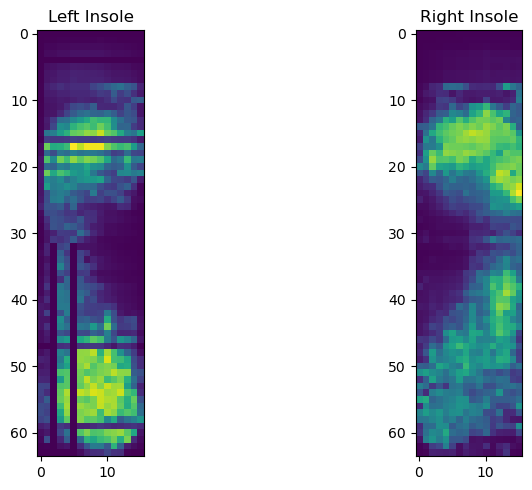

In [4]:
# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left Insole Plot
axs[0].imshow(img_avg_l)
axs[0].set_title("Left Insole")

# Right Insole Plot
axs[1].imshow(img_avg_r)
axs[1].set_title("Right Insole")

plt.tight_layout()
plt.show()

# Creating outline of foot

In [24]:
tunable_params = {
    'insole_dims': (64, 16),
    # Gaussian filter
    'pad_width': 1,
    'sigma': 1.0,
    'morph_size': 3,
    # Fixed threshold for the mask:
    'foot_mask_threshold_l': 100,
    'foot_mask_threshold_r': 800,
    # Toggle for Gaussian smoothing:
    'apply_gaussian': True,  
    'aggregation_window': 40,
    'lowpass_cutoff': 8,
    'fs': 50,
    'filter_order': 4,
    # Heel strike and toe off thresholds
    'h_th_r': 30,
    't_th_r': 30,
    'h_th_l': 30,
    't_th_l': 30,
    'strike_th_l': 2,
    'strike_th_r': 2,
    # Animation
    'animation_interval': 100,
}

In [ ]:
def extract_foot_mask(pressure_data, threshold=None, sigma=tunable_params['sigma'], 
                        morph_size=tunable_params['morph_size'], pad_width=tunable_params['pad_width']):
    """
    Extracts a binary foot mask from a pressure data array.
    If smoothing is disabled, the raw padded data is used.
    Uses a tunable threshold value (defaulting to tunable_params['foot_mask_threshold'])
    """
    padded_data = np.pad(pressure_data, pad_width=pad_width, mode='edge')
    
    # Apply Gaussian smoothing if enabled; otherwise, use the raw padded data.
    if tunable_params.get('apply_gaussian', True):
        processed_data = gaussian_filter(padded_data, sigma=sigma)
    else:
        processed_data = padded_data

    # Use the tunable threshold value if none is provided.
    if threshold is None:
        threshold = tunable_params.get('foot_mask_threshold', 0)

    binary_mask = processed_data > threshold
    structure = np.ones((morph_size, morph_size))
    cleaned_mask = binary_opening(binary_mask, structure=structure)
    cleaned_mask = binary_closing(cleaned_mask, structure=structure)
    mask = cleaned_mask[pad_width:-pad_width, pad_width:-pad_width]
    return mask

def aggregate_mask_central_window(insole_data, step, dim=tunable_params['insole_dims'], 
                                  window=tunable_params['aggregation_window'], threshold=None, 
                                  sigma=tunable_params['sigma'], morph_size=tunable_params['morph_size'], 
                                  pad_width=tunable_params['pad_width']):
    """
    Aggregates binary masks for frames in a window of +/- 'window' frames 
    around the mid-point (between strike and off).
    """
    start_idx = step['strike'][0]
    off_idx = step['off'][0] if step['off'] else (step['strike'][1] if len(step['strike']) > 1 else start_idx)
    mid_idx = (start_idx + off_idx) // 2
    window_start = max(start_idx, mid_idx - window)
    window_end = min(off_idx, mid_idx + window)
    agg_mask = np.zeros(dim, dtype=bool)
    for i in range(window_start, window_end + 1):
        frame = insole_data[i, :].reshape(dim, order='F')
        mask = extract_foot_mask(frame, threshold=threshold, sigma=sigma,
                         morph_size=morph_size, pad_width=pad_width)
        agg_mask = np.logical_or(agg_mask, mask)
    return agg_mask

def butter_lowpass_filter(data, cutoff=tunable_params['lowpass_cutoff'], fs=tunable_params['fs'], order=tunable_params['filter_order']):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def reshape_insole_grid(data, dims=tunable_params['insole_dims']):
    num_frames = data.shape[0]
    reshaped_data = np.empty((num_frames, dims[0], dims[1]), dtype=data.dtype)
    for i in range(num_frames):
        # Reshape using Fortran-order equivalent and flip the top half.
        frame = data[i].reshape(dims[1], dims[0]).T.copy()
        frame[:32, :] = np.flipud(frame[:32, :])
        reshaped_data[i] = frame
    return reshaped_data

def segment_insole_data(insole_data):
    toe_region = insole_data[:, :15, :]
    forefoot_region = insole_data[:, 15:33, :]
    midfoot_region = insole_data[:, 33:47, :]
    heel_region = insole_data[:, 47:, :]
    return heel_region, midfoot_region, forefoot_region, toe_region

def gait_segmentation(insole, h_th, t_th):
    insole = reshape_insole_grid(insole)
    heel_region, midfoot_region, forefoot_region, toe_region = segment_insole_data(insole)
    p_heel = np.mean(heel_region, axis=(1, 2))
    p_toe = np.mean(toe_region, axis=(1, 2))
    p_forefoot = np.mean(forefoot_region, axis=(1, 2))
    p_heel_filtered = butter_lowpass_filter(p_heel)
    p_fore_filtered = butter_lowpass_filter(p_toe + p_forefoot)
    p_heel_derivative = np.gradient(p_heel_filtered)
    p_fore_derivative = np.gradient(p_fore_filtered)
    hc_indices, _ = find_peaks(p_heel_derivative, height=h_th, distance=20)
    to_indices, _ = find_peaks(-p_fore_derivative, height=t_th, distance=20)
    return hc_indices, to_indices

def get_gait_event_masks(insole_r, insole_l, t_r, t_l, thresholds, dim=tunable_params['insole_dims']):
    """
    Extracts gait event timestamps (strike and off) and aggregates the foot outline mask
    for each step.
    """
    h_th_r, t_th_r, h_th_l, t_th_l, strike_th_l, strike_th_r = thresholds
    
    # --- Process Right Foot ---
    hc_indices_r, to_indices_r = gait_segmentation(insole_r, h_th_r, t_th_r)
    strike_r = hc_indices_r
    off_r = to_indices_r
    steps_r = []
    for i in range(len(strike_r) - 1):
        start, end = strike_r[i], strike_r[i + 1]
        if t_r[end] - t_r[start] > strike_th_r:
            continue
        step_off = [o for o in off_r if start <= o <= end]
        steps_r.append({'strike': [start, end], 'off': step_off})
    foot_mask_r = [aggregate_mask_central_window(insole_r, step, dim=dim, threshold=tunable_params.get('foot_mask_threshold_r'))
                   for step in steps_r]
    
    # --- Process Left Foot ---
    hc_indices_l, to_indices_l = gait_segmentation(insole_l, h_th_l, t_th_l)
    strike_l = hc_indices_l
    off_l = to_indices_l
    steps_l = []
    for i in range(len(strike_l) - 1):
        start, end = strike_l[i], strike_l[i + 1]
        if t_l[end] - t_l[start] > strike_th_l:
            continue
        step_off = [o for o in off_l if start <= o <= end]
        steps_l.append({'strike': [start, end], 'off': step_off})
    foot_mask_l = [aggregate_mask_central_window(insole_l, step, dim=dim, threshold=tunable_params.get('foot_mask_threshold_l'))
                   for step in steps_l]
    
    return {
        'steps_r': steps_r,
        'steps_l': steps_l,
        'foot_mask_r': foot_mask_r,
        'foot_mask_l': foot_mask_l,
    }

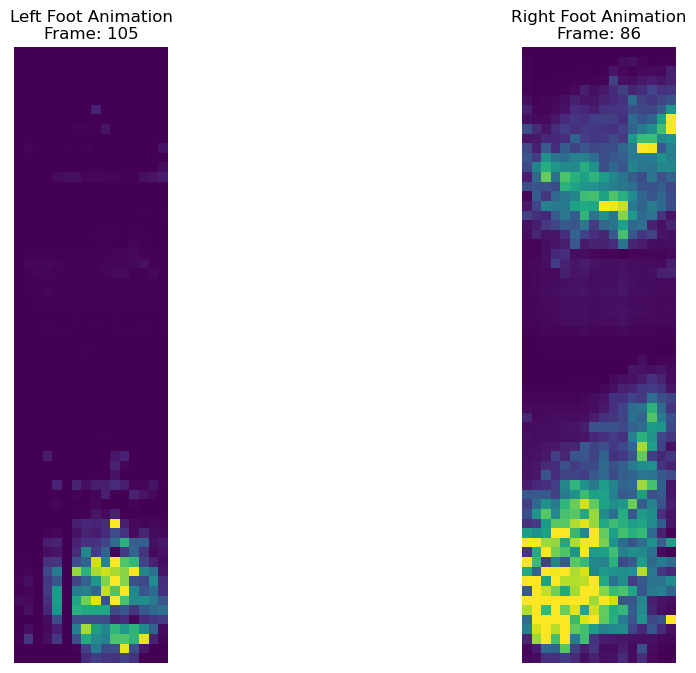

In [7]:
# Animate a single step to confirm segmentation
# Define thresholds for [h_th_r, t_th_r, h_th_l, t_th_l, strike_th_l, strike_th_r]
thresholds = [
    tunable_params['h_th_r'], tunable_params['t_th_r'], 
    tunable_params['h_th_l'], tunable_params['t_th_l'], 
    tunable_params['strike_th_l'], tunable_params['strike_th_r']
]

# Compute Gait Event Masks
gait_events = get_gait_event_masks(insoleAll_r, insoleAll_l, t_insole_r, t_insole_l, thresholds, dim=tunable_params['insole_dims'])

# For animation, select the first valid step for each foot.
selected_step_r = gait_events['steps_r'][0]
selected_step_l = gait_events['steps_l'][0]

# Extract step frames for right and left feet.
start_idx_r = selected_step_r['strike'][0]
off_idx_r = selected_step_r['off'][0] if selected_step_r['off'] else (selected_step_r['strike'][1] if len(selected_step_r['strike']) > 1 else start_idx_r)
step_frames_r = insoleAll_r[start_idx_r:off_idx_r+1, :]

start_idx_l = selected_step_l['strike'][0]
off_idx_l = selected_step_l['off'][0] if selected_step_l['off'] else (selected_step_l['strike'][1] if len(selected_step_l['strike']) > 1 else start_idx_l)
step_frames_l = insoleAll_l[start_idx_l:off_idx_l+1, :]

# --- Animation: Arrange so Left Foot is on the left and Right Foot is on the right ---
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 8))

# Left Foot Animation: only flip the top half.
init_frame_l = step_frames_l[0].reshape(tunable_params['insole_dims'], order='F')
init_frame_l[:32, :] = np.flipud(init_frame_l[:32, :])
im_l = ax_l.imshow(init_frame_l, cmap='viridis', interpolation='nearest')
ax_l.axis('off')
ax_l.set_title("Left Foot Animation\nFrame: {}".format(start_idx_l))

# Right Foot Animation: flip left-right then flip the top half.
init_frame_r = step_frames_r[0].reshape(tunable_params['insole_dims'], order='F')
init_frame_r = np.fliplr(init_frame_r)
init_frame_r[:32, :] = np.flipud(init_frame_r[:32, :])
im_r = ax_r.imshow(init_frame_r, cmap='viridis', interpolation='nearest')
ax_r.axis('off')
ax_r.set_title("Right Foot Animation\nFrame: {}".format(start_idx_r))

n_frames_r = step_frames_r.shape[0]
n_frames_l = step_frames_l.shape[0]
max_frames = max(n_frames_r, n_frames_l)

def update(frame_index):
    # Update Right Foot Animation (right subplot)
    idx_r = frame_index if frame_index < n_frames_r else n_frames_r - 1
    frame_data_r = step_frames_r[idx_r].reshape(tunable_params['insole_dims'], order='F')
    frame_data_r = np.fliplr(frame_data_r)
    frame_data_r[:32, :] = np.flipud(frame_data_r[:32, :])
    im_r.set_data(frame_data_r)
    ax_r.set_title(f"Right Foot Animation\nFrame: {start_idx_r + idx_r}")
    
    # Update Left Foot Animation (left subplot)
    idx_l = frame_index if frame_index < n_frames_l else n_frames_l - 1
    frame_data_l = step_frames_l[idx_l].reshape(tunable_params['insole_dims'], order='F')
    frame_data_l[:32, :] = np.flipud(frame_data_l[:32, :])
    im_l.set_data(frame_data_l)
    ax_l.set_title(f"Left Foot Animation\nFrame: {start_idx_l + idx_l}")
    
    return [im_l, im_r]

anim = animation.FuncAnimation(fig, update, frames=range(max_frames), interval=tunable_params['animation_interval'], blit=False)
HTML(anim.to_jshtml())

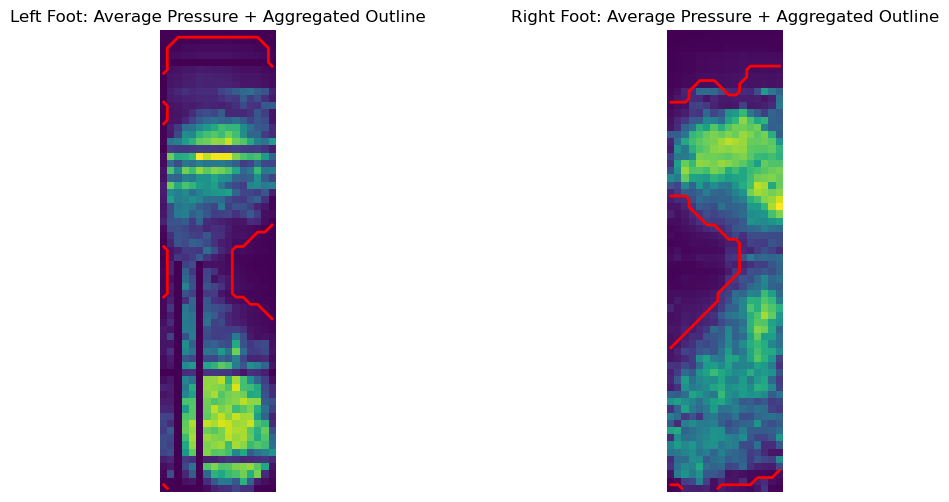

In [25]:
# Compute aggregated masks using a central window (± aggregation_window frames).
agg_mask_r = aggregate_mask_central_window(
    insoleAll_r, selected_step_r, dim=tunable_params['insole_dims'],
    window=tunable_params['aggregation_window'], threshold=tunable_params.get('foot_mask_threshold_r')
)
agg_mask_l = aggregate_mask_central_window(
    insoleAll_l, selected_step_l, dim=tunable_params['insole_dims'],
    window=tunable_params['aggregation_window'], threshold=tunable_params.get('foot_mask_threshold_l')
)
agg_mask_r = np.fliplr(agg_mask_r)

# Extract contours from the aggregated masks.
contours_r = find_contours(agg_mask_r, level=0.5)
contours_l = find_contours(agg_mask_l, level=0.5)

# Plot the aggregated outlines on the average pressure images.
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

# Left Foot Plot (left subplot)
ax_l.imshow(img_avg_l, cmap='viridis', interpolation='nearest')
for contour in contours_l:
    ax_l.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
ax_l.set_title("Left Foot: Average Pressure + Aggregated Outline")
ax_l.axis('off')

# Right Foot Plot (right subplot)
ax_r.imshow(img_avg_r, cmap='viridis', interpolation='nearest')
for contour in contours_r:
    ax_r.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
ax_r.set_title("Right Foot: Average Pressure + Aggregated Outline")
ax_r.axis('off')

plt.show()

# Dividing by joints

## Drawing boundary lines

In [26]:
# Helper function to rotate graphed line
def get_angled_line_coords(y_center, angle_deg, x_min=0, x_max=15, n_points=50):

    """
    Returns arrays of (x_vals, y_vals) in "image coordinates" for a line:
      - spanning from x_min to x_max
      - passing through (x_center, y_center) at the midpoint in x
      - tilted by angle_deg. (Positive angle = 'counterclockwise' in normal math.)
        However, note that in an imshow with origin='upper', the y-axis is inverted.
    """
    angle_rad = np.deg2rad(angle_deg)

    x_vals = np.linspace(x_min, x_max, n_points)
    slope = -np.tan(angle_rad)

    x_center = (x_min + x_max) / 2.0

    # Equation of the line in image coords: y = y_center + slope*(x - x_center)
    y_vals = y_center + slope * (x_vals - x_center)

    return x_vals, y_vals

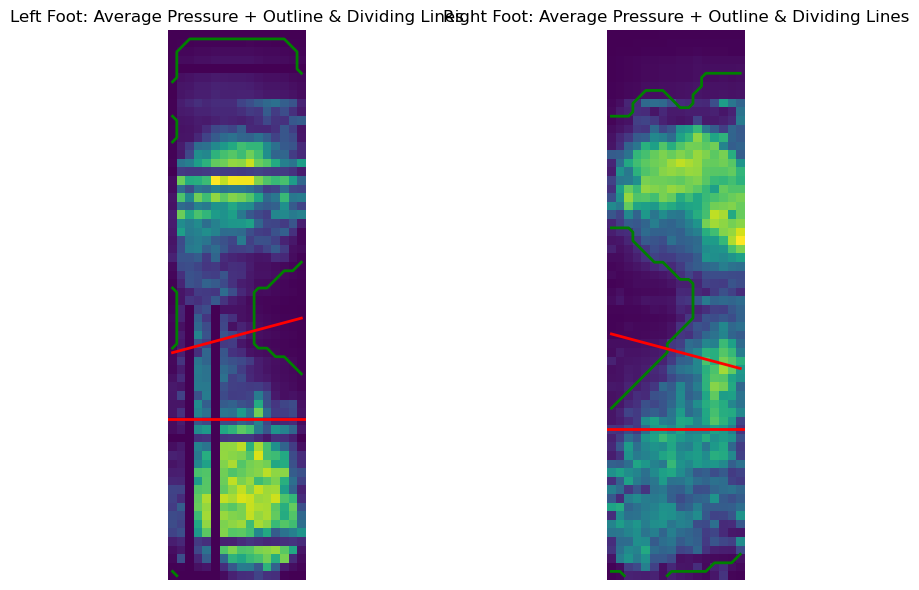

In [28]:
# Compute the extreme points of the aggregated masks from the first step
first_step_l = gait_events['steps_l'][0]
first_step_r = gait_events['steps_r'][0]

# Get the aggregated mask for the first step of each foot
agg_mask_l = aggregate_mask_central_window(
    insoleAll_l, first_step_l, 
    dim=tunable_params['insole_dims'], 
    window=tunable_params['aggregation_window'],
    threshold=tunable_params.get('foot_mask_threshold_l')
)
agg_mask_r_flipped = np.fliplr(aggregate_mask_central_window(
    insoleAll_r, first_step_r, 
    dim=tunable_params['insole_dims'], 
    window=tunable_params['aggregation_window'],
    threshold=tunable_params.get('foot_mask_threshold_r')
))

# Find the boundaries from the aggregated masks
rows_l, cols_l = np.where(agg_mask_l)
rows_r, cols_r = np.where(agg_mask_r_flipped)

# Left foot boundaries from aggregated mask
foot_top_l = rows_l.min()
foot_bot_l = rows_l.max()
foot_left_l = cols_l.min()
foot_right_l = cols_l.max()
# Right foot boundaries from aggregated mask
foot_top_r = rows_r.min()
foot_bot_r = rows_r.max()
foot_left_r = cols_r.min()
foot_right_r = cols_r.max()

# Compute vertical foot lengths for proportional lines
foot_length_l = foot_bot_l - foot_top_l + 1
foot_length_r = foot_bot_r - foot_top_r + 1

# Define dividing lines
line1_l = foot_top_l + 0.54 * foot_length_l  # 54% from the top for the left foot
line2_l = foot_bot_l - 0.29 * foot_length_l  # 29% from the bottom for the left foot
line1_r = foot_top_r + 0.54 * foot_length_r  # 54% from the top for the right foot
line2_r = foot_bot_r - 0.29 * foot_length_r  # 29% from the bottom for the right foot

# Extract the contours from the aggregated masks
contours_l = find_contours(agg_mask_l, level=0.5)
contours_r = find_contours(agg_mask_r_flipped, level=0.5)  # Use the flipped mask for contours

# Plot the average pressure images with the aggregated outline and dividing lines
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

# Left Foot Plot - using average pressure
ax_l.imshow(img_avg_l, cmap='viridis', interpolation='nearest')
# Plot the aggregated foot outline in green:
for contour in contours_l:
    ax_l.plot(contour[:, 1], contour[:, 0], 'g', linewidth=2)
# Draw dividing lines on the left foot:
angle_left = 15  # positive angle for left foot
xl1, yl1 = get_angled_line_coords(line1_l, angle_left,
                                  x_min=foot_left_l, x_max=foot_right_l, n_points=50)
ax_l.plot(xl1, yl1, color='r', linewidth=2)  # angled line
ax_l.axhline(line2_l, color='r', linewidth=2)  # horizontal line
ax_l.set_title("Left Foot: Average Pressure + Outline & Dividing Lines")
ax_l.axis('off')

# Right Foot Plot - using average pressure
ax_r.imshow(img_avg_r, cmap='viridis', interpolation='nearest')
# Plot the aggregated foot outline in green:
for contour in contours_r:
    ax_r.plot(contour[:, 1], contour[:, 0], 'g', linewidth=2)
# Draw dividing lines on the right foot:
angle_right = -15  # negative angle for right foot
xr1, yr1 = get_angled_line_coords(line1_r, angle_right,
                                 x_min=foot_left_r, x_max=foot_right_r, n_points=50)
ax_r.plot(xr1, yr1, color='r', linewidth=2)  # angled line
ax_r.axhline(line2_r, color='r', linewidth=2)  # horizontal line
ax_r.set_title("Right Foot: Average Pressure + Outline & Dividing Lines")
ax_r.axis('off')

plt.tight_layout()
plt.show()

## Assigning datapoints based on boundaries

In [276]:
# Assign datapoints based on division above
forefoot_left_data  = []
midfoot_left_data   = []
hindfoot_left_data  = []

forefoot_right_data = []
midfoot_right_data  = []
hindfoot_right_data = []

# Precompute slopes from the specified angles.
slope_left  = -np.tan(np.deg2rad(angle_left))
slope_right = -np.tan(np.deg2rad(angle_right))
x_center = 7.5  # center in the x-direction (columns)

# --- Process Left Foot: Loop over each detected step ---
for step in gait_events['steps_l']:
    # Determine the frame indices for this left foot step.
    start_idx = step['strike'][0]
    if step['off']:
        off_idx = step['off'][0]
    else:
        off_idx = step['strike'][1]
        
    # Compute the aggregated mask for this step.
    agg_mask = aggregate_mask_central_window(insoleAll_l, step, 
                                             dim=tunable_params['insole_dims'], 
                                             window=tunable_params['aggregation_window'])
    # Determine boundaries of the foot (from the aggregated mask).
    rows, cols = np.where(agg_mask)
    if len(rows) == 0:
        continue  # Skip this step if the mask is empty.
    foot_top   = rows.min()
    foot_bot   = rows.max()
    foot_left  = cols.min()
    foot_right = cols.max()
    foot_length = foot_bot - foot_top + 1

    # Compute the dividing lines based on the foot outline.
    # line1 is 54% down from the top edge; line2 is 29% up from the bottom edge.
    line1 = foot_top + 0.54 * foot_length
    line2 = foot_bot - 0.29 * foot_length

    # Loop over each frame for this step.
    for i in range(start_idx, off_idx + 1):
        time_i = t_insole_l[i]
        # Reshape and flip the frame as done before.
        frame = np.reshape(insoleAll_l[i, :], (64, 16), order='F')
        frame[:32, :] = np.flipud(frame[:32, :])
        
        # Classify each pixel that is inside the aggregated foot mask.
        for col in range(16):
            # For the left foot, compute the angled boundary at this column.
            boundary1_col = line1 + slope_left * (col - x_center)
            for row in range(64):
                # Only consider pixels within the foot outline.
                if not agg_mask[row, col]:
                    continue
                val = frame[row, col]
                # Use the dividing lines to assign the pixel.
                if row < boundary1_col:
                    forefoot_left_data.append([time_i, row, col, val])
                elif row < line2:
                    midfoot_left_data.append([time_i, row, col, val])
                else:
                    hindfoot_left_data.append([time_i, row, col, val])

# --- Process Right Foot: Loop over each detected step ---
for step in gait_events['steps_r']:
    start_idx = step['strike'][0]
    if step['off']:
        off_idx = step['off'][0]
    else:
        off_idx = step['strike'][1]
        
    # Compute the aggregated mask for this right foot step.
    agg_mask = aggregate_mask_central_window(insoleAll_r, step, 
                                             dim=tunable_params['insole_dims'], 
                                             window=tunable_params['aggregation_window'])
    rows, cols = np.where(agg_mask)
    if len(rows) == 0:
        continue
    foot_top   = rows.min()
    foot_bot   = rows.max()
    foot_left  = cols.min()
    foot_right = cols.max()
    foot_length = foot_bot - foot_top + 1
    
    line1 = foot_top + 0.54 * foot_length
    line2 = foot_bot - 0.29 * foot_length

    for i in range(start_idx, off_idx + 1):
        time_i = t_insole_r[i]
        # Reshape the frame and perform the necessary flips for right foot.
        frame = np.reshape(insoleAll_r[i, :], (64, 16), order='F')
        frame = np.fliplr(frame)
        frame[:32, :] = np.flipud(frame[:32, :])
        
        for col in range(16):
            boundary1_col = line1 + slope_right * (col - x_center)
            for row in range(64):
                if not agg_mask[row, col]:
                    continue
                val = frame[row, col]
                if row < boundary1_col:
                    forefoot_right_data.append([time_i, row, col, val])
                elif row < line2:
                    midfoot_right_data.append([time_i, row, col, val])
                else:
                    hindfoot_right_data.append([time_i, row, col, val])


In [277]:
columns = ['timestamp', 'row', 'col', 'pressure']

forefoot_left_df  = pd.DataFrame(forefoot_left_data,  columns=columns)
midfoot_left_df   = pd.DataFrame(midfoot_left_data,   columns=columns)
hindfoot_left_df  = pd.DataFrame(hindfoot_left_data,  columns=columns)

forefoot_right_df = pd.DataFrame(forefoot_right_data, columns=columns)
midfoot_right_df  = pd.DataFrame(midfoot_right_data,  columns=columns)
hindfoot_right_df = pd.DataFrame(hindfoot_right_data, columns=columns)

# Ensure the timestamps are of the proper type.
forefoot_left_df['timestamp']  = forefoot_left_df['timestamp'].astype(np.float64)
midfoot_left_df['timestamp']   = midfoot_left_df['timestamp'].astype(np.float64)
hindfoot_left_df['timestamp']  = hindfoot_left_df['timestamp'].astype(np.float64)
forefoot_right_df['timestamp'] = forefoot_right_df['timestamp'].astype(np.float64)
midfoot_right_df['timestamp']  = midfoot_right_df['timestamp'].astype(np.float64)
hindfoot_right_df['timestamp'] = hindfoot_right_df['timestamp'].astype(np.float64)

# Save the DataFrames to CSV files.
forefoot_left_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/forefoot_left.csv",  index=False)
midfoot_left_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/midfoot_left.csv",    index=False)
hindfoot_left_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/hindfoot_left.csv",  index=False)

forefoot_right_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/forefoot_right.csv", index=False)
midfoot_right_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/midfoot_right.csv",   index=False)
hindfoot_right_df.to_csv("data_by_section/GAIT080624-01/walk_4/joint/hindfoot_right.csv", index=False)

In [278]:
def build_first_step_color_image(csv_fore, csv_mid, csv_hind, region_colors, step_time_range, is_right_foot=False):
    """
    Reads three CSV files (forefoot, midfoot, hindfoot) for a single foot,
    filters for data only from the specified step_time_range, and returns 
    a color-coded image that varies brightness by pressure.
    
    For the right foot, we flip columns (c -> 15 - c) to match the left foot's display orientation.
    """
    # 1) Load each CSV
    df_fore = pd.read_csv(csv_fore)
    df_mid  = pd.read_csv(csv_mid)
    df_hind = pd.read_csv(csv_hind)
    
    # 2) Filter by time range for this single step
    start_time, end_time = float(step_time_range[0]), float(step_time_range[1])
    df_fore = df_fore[(df_fore['timestamp'] >= start_time) & (df_fore['timestamp'] <= end_time)]
    df_mid  = df_mid[(df_mid['timestamp'] >= start_time) & (df_mid['timestamp'] <= end_time)]
    df_hind = df_hind[(df_hind['timestamp'] >= start_time) & (df_hind['timestamp'] <= end_time)]
    
    # 3) Concatenate all rows to find a global max pressure (so we can normalize brightness)
    all_pressures = pd.concat([df_fore['pressure'], df_mid['pressure'], df_hind['pressure']])
    if all_pressures.empty:
        max_pressure = 1.0  # fallback to 1 if there's no data
    else:
        max_pressure = all_pressures.max()
    
    # 4) Group each region by (row, col) => mean pressure
    group_fore = df_fore.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_mid  = df_mid.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_hind = df_hind.groupby(['row', 'col'])['pressure'].mean().reset_index()
    
    # 5) Build an empty color image (64 x 16 x 3)
    foot_img = np.zeros((64, 16, 3), dtype=float)

    # Helper to fill in region with scaled brightness
    def fill_region(df_group, base_color):
        for _, row_data in df_group.iterrows():
            r = int(row_data['row'])
            c = int(row_data['col'])
            pressure_val = row_data['pressure']
            # Normalize pressure => scale factor in [0..1]
            brightness = pressure_val / max_pressure if max_pressure > 0 else 0.0
            
            # Flip columns if this is the right foot
            if is_right_foot:
                c = 15 - c

            # Multiply the base color by the brightness
            foot_img[r, c, :] = base_color * brightness

    # 6) Fill each region with scaled brightness
    fill_region(group_fore, region_colors['forefoot'])
    fill_region(group_mid,  region_colors['midfoot'])
    fill_region(group_hind, region_colors['hindfoot'])
    
    return foot_img

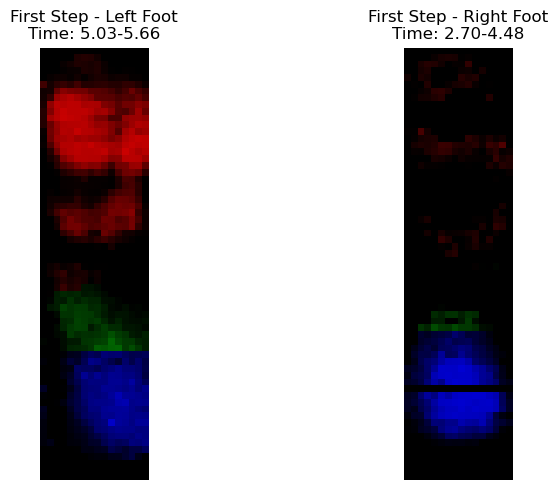

In [279]:
first_step_l = gait_events['steps_l'][0]
first_step_r = gait_events['steps_r'][0]

left_start_idx = first_step_l['strike'][0]
left_end_idx   = first_step_l['off'][0] if first_step_l['off'] else first_step_l['strike'][1]
left_start_time = float(t_insole_l[left_start_idx][0])
left_end_time   = float(t_insole_l[left_end_idx][0])
left_time_range = (left_start_time, left_end_time)

right_start_idx = first_step_r['strike'][0]
right_end_idx   = first_step_r['off'][0] if first_step_r['off'] else first_step_r['strike'][1]
right_start_time = float(t_insole_r[right_start_idx][0])
right_end_time   = float(t_insole_r[right_end_idx][0])
right_time_range = (right_start_time, right_end_time)

# --- Define the same Red/Green/Blue mapping for forefoot, midfoot, hindfoot ---
region_colors = {
    'forefoot': np.array([1.0, 0.0, 0.0]),  # Red
    'midfoot':  np.array([0.0, 1.0, 0.0]),  # Green
    'hindfoot': np.array([0.0, 0.0, 1.0])   # Blue
}

# Build the color-coded images (with pressure-based brightness) for the first step of each foot
foot_left_img = build_first_step_color_image(
    'data_by_section/GAIT080624-01/walk_4/joint/forefoot_left.csv',
    'data_by_section/GAIT080624-01/walk_4/joint/midfoot_left.csv',
    'data_by_section/GAIT080624-01/walk_4/joint/hindfoot_left.csv',
    region_colors,
    left_time_range,
    is_right_foot=False
)

foot_right_img = build_first_step_color_image(
    'data_by_section/GAIT080624-01/walk_4/joint/forefoot_right.csv',
    'data_by_section/GAIT080624-01/walk_4/joint/midfoot_right.csv',
    'data_by_section/GAIT080624-01/walk_4/joint/hindfoot_right.csv',
    region_colors,
    right_time_range,
    is_right_foot=True
)

# --- Plot side by side ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(foot_left_img, origin='upper')
plt.title(f"First Step - Left Foot\nTime: {left_time_range[0]:.2f}-{left_time_range[1]:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(foot_right_img, origin='upper')
plt.title(f"First Step - Right Foot\nTime: {right_time_range[0]:.2f}-{right_time_range[1]:.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()

# Dividing into 6 regions (joints + center line)

In [45]:
# Helper function to rotate graphed line
def get_angled_line_coords(y_center, angle_deg, x_min=0, x_max=15, n_points=50):
    """
    Returns arrays of (x_vals, y_vals) in "image coordinates" for a line:
      - spanning from x_min to x_max
      - passing through (x_center, y_center) at the midpoint in x
      - tilted by angle_deg. (Positive angle = 'counterclockwise' in normal math.)
        However, note that in an imshow with origin='upper', the y-axis is inverted.
    """
    angle_rad = np.deg2rad(angle_deg)
    x_vals = np.linspace(x_min, x_max, n_points)
    slope = -np.tan(angle_rad)
    x_center = (x_min + x_max) / 2.0
    # Equation of the line in image coords: y = y_center + slope*(x - x_center)
    y_vals = y_center + slope * (x_vals - x_center)
    return x_vals, y_vals

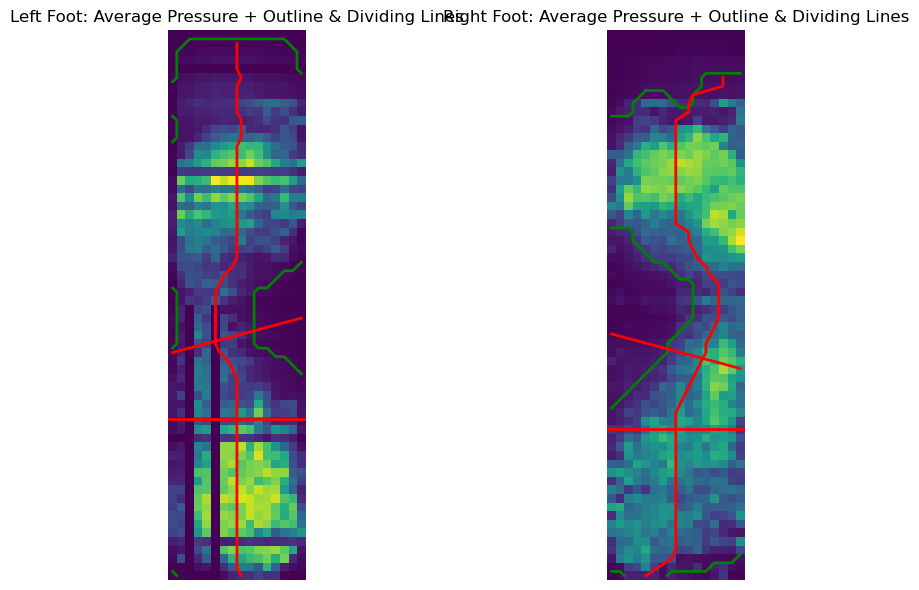

In [46]:
# Compute the extreme points of the aggregated masks from the first step
first_step_l = gait_events['steps_l'][0]
first_step_r = gait_events['steps_r'][0]

# Get the aggregated mask for the first step of each foot
agg_mask_l = aggregate_mask_central_window(
    insoleAll_l, first_step_l, 
    dim=tunable_params['insole_dims'], 
    window=tunable_params['aggregation_window'],
    threshold=tunable_params.get('foot_mask_threshold_l')
)
agg_mask_r_flipped = np.fliplr(aggregate_mask_central_window(
    insoleAll_r, first_step_r, 
    dim=tunable_params['insole_dims'], 
    window=tunable_params['aggregation_window'],
    threshold=tunable_params.get('foot_mask_threshold_r')
))

# Find the boundaries from the aggregated masks
rows_l, cols_l = np.where(agg_mask_l)
rows_r, cols_r = np.where(agg_mask_r_flipped)

# Left foot boundaries from aggregated mask
foot_top_l = rows_l.min()
foot_bot_l = rows_l.max()
foot_left_l = cols_l.min()
foot_right_l = cols_l.max()
# Right foot boundaries from aggregated mask
foot_top_r = rows_r.min()
foot_bot_r = rows_r.max()
foot_left_r = cols_r.min()
foot_right_r = cols_r.max()

# Compute vertical foot lengths for proportional lines
foot_length_l = foot_bot_l - foot_top_l + 1
foot_length_r = foot_bot_r - foot_top_r + 1

# Define dividing lines (vertical separation for fore/mid/hind)
line1_l = foot_top_l + 0.54 * foot_length_l  # 54% from the top for the left foot
line2_l = foot_bot_l - 0.29 * foot_length_l   # 29% from the bottom for the left foot
line1_r = foot_top_r + 0.54 * foot_length_r    # 54% from the top for the right foot
line2_r = foot_bot_r - 0.29 * foot_length_r     # 29% from the bottom for the right foot

# **EDIT**: Instead of using a constant mid-column, compute a row‐specific medial–lateral dividing line 
x_mid_line_l = []
y_mid_line_l = []
for row in range(foot_top_l, foot_bot_l + 1):
    cols_in_row = np.where(agg_mask_l[row, :])[0]
    if cols_in_row.size > 0:
        mid_x = (cols_in_row.min() + cols_in_row.max()) / 2.0
        x_mid_line_l.append(mid_x)
        y_mid_line_l.append(row)

x_mid_line_r = []
y_mid_line_r = []
for row in range(foot_top_r, foot_bot_r + 1):
    cols_in_row = np.where(agg_mask_r_flipped[row, :])[0]
    if cols_in_row.size > 0:
        mid_x = (cols_in_row.min() + cols_in_row.max()) / 2.0
        x_mid_line_r.append(mid_x)
        y_mid_line_r.append(row)

# Extract the contours from the aggregated masks
contours_l = find_contours(agg_mask_l, level=0.5)
contours_r = find_contours(agg_mask_r_flipped, level=0.5)  # Use the flipped mask for contours

# Plot the average pressure images with the aggregated outline and dividing lines
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

# Left Foot Plot - using average pressure
ax_l.imshow(img_avg_l, cmap='viridis', interpolation='nearest')
for contour in contours_l:
    ax_l.plot(contour[:, 1], contour[:, 0], 'g', linewidth=2)
# Draw dividing lines on the left foot:
angle_left = 15  # positive angle for left foot
xl1, yl1 = get_angled_line_coords(line1_l, angle_left,
                                  x_min=foot_left_l, x_max=foot_right_l, n_points=50)
ax_l.plot(xl1, yl1, color='r', linewidth=2)  # angled line
ax_l.axhline(line2_l, color='r', linewidth=2)  # horizontal line
# **EDIT**: Draw the computed medial–lateral dividing line (mask-based) for the left foot.
ax_l.plot(x_mid_line_l, y_mid_line_l, color='r', linewidth=2)
ax_l.set_title("Left Foot: Average Pressure + Outline & Dividing Lines")
ax_l.axis('off')

# Right Foot Plot - using average pressure
ax_r.imshow(img_avg_r, cmap='viridis', interpolation='nearest')
for contour in contours_r:
    ax_r.plot(contour[:, 1], contour[:, 0], 'g', linewidth=2)
angle_right = -15  # negative angle for right foot
xr1, yr1 = get_angled_line_coords(line1_r, angle_right,
                                  x_min=foot_left_r, x_max=foot_right_r, n_points=50)
ax_r.plot(xr1, yr1, color='r', linewidth=2)  # angled line
ax_r.axhline(line2_r, color='r', linewidth=2)  # horizontal line
# **EDIT**: Draw the computed medial–lateral dividing line (mask-based) for the right foot.
ax_r.plot(x_mid_line_r, y_mid_line_r, color='r', linewidth=2)
ax_r.set_title("Right Foot: Average Pressure + Outline & Dividing Lines")
ax_r.axis('off')

plt.tight_layout()
plt.show()

In [47]:
# **EDIT**: Initialize new lists for six regions for the left foot.
forelat_left_data  = []
foremed_left_data  = []
midlat_left_data   = []
midmed_left_data   = []
hindlat_left_data  = []
hindmed_left_data  = []

# Precompute slopes from the specified angles.
slope_left  = -np.tan(np.deg2rad(angle_left))
slope_right = -np.tan(np.deg2rad(angle_right))
x_center = 7.5  # center in the x-direction (columns)

# --- Process Left Foot: Loop over each detected step ---
for step in gait_events['steps_l']:
    # Determine the frame indices for this left foot step.
    start_idx = step['strike'][0]
    if step['off']:
        off_idx = step['off'][0]
    else:
        off_idx = step['strike'][1]
        
    # Compute the aggregated mask for this step.
    agg_mask = aggregate_mask_central_window(insoleAll_l, step, 
                                             dim=tunable_params['insole_dims'], 
                                             window=tunable_params['aggregation_window'],
                                             threshold=tunable_params.get('foot_mask_threshold_l'))
    # Determine boundaries of the foot (from the aggregated mask).
    rows, cols = np.where(agg_mask)
    if len(rows) == 0:
        continue  # Skip this step if the mask is empty.
    foot_top   = rows.min()
    foot_bot   = rows.max()
    foot_left  = cols.min()
    foot_right = cols.max()
    foot_length = foot_bot - foot_top + 1

    # Compute the dividing lines based on the foot outline.
    # line1 is 54% down from the top edge; line2 is 29% up from the bottom edge.
    line1 = foot_top + 0.54 * foot_length
    line2 = foot_bot - 0.29 * foot_length

    # **EDIT**: Compute row-specific medial–lateral midline for this step.
    midline_dict = {}
    for row in range(foot_top, foot_bot + 1):
        cols_in_row = np.where(agg_mask[row, :])[0]
        if cols_in_row.size > 0:
            midline_dict[row] = (cols_in_row.min() + cols_in_row.max()) / 2.0

    # Loop over each frame for this step.
    for i in range(start_idx, off_idx + 1):
        time_i = t_insole_l[i]
        # Reshape and flip the frame as done before.
        frame = np.reshape(insoleAll_l[i, :], (64, 16), order='F')
        frame[:32, :] = np.flipud(frame[:32, :])
        
        # Classify each pixel that is inside the aggregated foot mask.
        for col in range(16):
            # For the left foot, compute the angled boundary at this column.
            boundary1_col = line1 + slope_left * (col - x_center)
            for row in range(64):
                if not agg_mask[row, col]:
                    continue
                val = frame[row, col]
                # Use row-specific midline if available, else fallback to constant mid
                current_mid = midline_dict.get(row, (foot_left + foot_right) / 2)
                if row < boundary1_col:
                    # Forefoot region
                    if col < current_mid:
                        forelat_left_data.append([time_i, row, col, val])
                    else:
                        foremed_left_data.append([time_i, row, col, val])
                elif row < line2:
                    # Midfoot region
                    if col < current_mid:
                        midlat_left_data.append([time_i, row, col, val])
                    else:
                        midmed_left_data.append([time_i, row, col, val])
                else:
                    # Hindfoot region
                    if col < current_mid:
                        hindlat_left_data.append([time_i, row, col, val])
                    else:
                        hindmed_left_data.append([time_i, row, col, val])

# **EDIT**: Initialize new lists for six regions for the right foot.
forelat_right_data = []
foremed_right_data = []
midlat_right_data  = []
midmed_right_data  = []
hindlat_right_data = []
hindmed_right_data = []

# --- Process Right Foot: Loop over each detected step ---
for step in gait_events['steps_r']:
    start_idx = step['strike'][0]
    if step['off']:
        off_idx = step['off'][0]
    else:
        off_idx = step['strike'][1]
        
    # Compute the aggregated mask for this right foot step.
    agg_mask = aggregate_mask_central_window(insoleAll_r, step, 
                                             dim=tunable_params['insole_dims'], 
                                             window=tunable_params['aggregation_window'],
                                             threshold=tunable_params.get('foot_mask_threshold_r'))
    # **EDIT**: Flip the aggregated mask for right foot to match display orientation.
    agg_mask = np.fliplr(agg_mask)
    rows, cols = np.where(agg_mask)
    if len(rows) == 0:
        continue
    foot_top   = rows.min()
    foot_bot   = rows.max()
    foot_left  = cols.min()
    foot_right = cols.max()
    foot_length = foot_bot - foot_top + 1
    
    line1 = foot_top + 0.54 * foot_length
    line2 = foot_bot - 0.29 * foot_length

    # **EDIT**: Compute row-specific medial–lateral midline for this step.
    midline_dict = {}
    for row in range(foot_top, foot_bot + 1):
        cols_in_row = np.where(agg_mask[row, :])[0]
        if cols_in_row.size > 0:
            midline_dict[row] = (cols_in_row.min() + cols_in_row.max()) / 2.0

    for i in range(start_idx, off_idx + 1):
        time_i = t_insole_r[i]
        # Reshape the frame and perform the necessary flips for right foot.
        frame = np.reshape(insoleAll_r[i, :], (64, 16), order='F')
        frame = np.fliplr(frame)
        frame[:32, :] = np.flipud(frame[:32, :])
        
        for col in range(16):
            boundary1_col = line1 + slope_right * (col - x_center)
            for row in range(64):
                if not agg_mask[row, col]:
                    continue
                val = frame[row, col]
                # **EDIT**: Use row-specific midline if available, else fallback to constant mid
                current_mid = midline_dict.get(row, (foot_left + foot_right) / 2)
                if row < boundary1_col:
                    # Forefoot region
                    # For right foot, lateral is the right side (col >= current_mid)
                    if col >= current_mid:
                        forelat_right_data.append([time_i, row, col, val])
                    else:
                        foremed_right_data.append([time_i, row, col, val])
                elif row < line2:
                    # Midfoot region
                    if col >= current_mid:
                        midlat_right_data.append([time_i, row, col, val])
                    else:
                        midmed_right_data.append([time_i, row, col, val])
                else:
                    # Hindfoot region
                    if col >= current_mid:
                        hindlat_right_data.append([time_i, row, col, val])
                    else:
                        hindmed_right_data.append([time_i, row, col, val])

# Create DataFrames and save CSV files for the six regions per foot.
columns = ['timestamp', 'row', 'col', 'pressure']

# Left Foot CSVs
forelat_left_df  = pd.DataFrame(forelat_left_data,  columns=columns)
foremed_left_df  = pd.DataFrame(foremed_left_data,  columns=columns)
midlat_left_df   = pd.DataFrame(midlat_left_data,   columns=columns)
midmed_left_df   = pd.DataFrame(midmed_left_data,   columns=columns)
hindlat_left_df  = pd.DataFrame(hindlat_left_data,  columns=columns)
hindmed_left_df  = pd.DataFrame(hindmed_left_data,  columns=columns)

# Right Foot CSVs
forelat_right_df = pd.DataFrame(forelat_right_data, columns=columns)
foremed_right_df = pd.DataFrame(foremed_right_data, columns=columns)
midlat_right_df  = pd.DataFrame(midlat_right_data,  columns=columns)
midmed_right_df  = pd.DataFrame(midmed_right_data,  columns=columns)
hindlat_right_df = pd.DataFrame(hindlat_right_data, columns=columns)
hindmed_right_df = pd.DataFrame(hindmed_right_data, columns=columns)

# Ensure the timestamps are of the proper type.
for df in [forelat_left_df, foremed_left_df, midlat_left_df, midmed_left_df, hindlat_left_df, hindmed_left_df,
           forelat_right_df, foremed_right_df, midlat_right_df, midmed_right_df, hindlat_right_df, hindmed_right_df]:
    df['timestamp'] = df['timestamp'].astype(np.float64)

# Save the DataFrames to CSV files with the new filepaths.
forelat_left_df.to_csv("data_by_section/021925/walk_2/six/forelat_left.csv",  index=False)
foremed_left_df.to_csv("data_by_section/021925/walk_2/six/foremed_left.csv",  index=False)
midlat_left_df.to_csv("data_by_section/021925/walk_2/six/midlat_left.csv",    index=False)
midmed_left_df.to_csv("data_by_section/021925/walk_2/six/midmed_left.csv",    index=False)
hindlat_left_df.to_csv("data_by_section/021925/walk_2/six/hindlat_left.csv",  index=False)
hindmed_left_df.to_csv("data_by_section/021925/walk_2/six/hindmed_left.csv",  index=False)

forelat_right_df.to_csv("data_by_section/021925/walk_2/six/forelat_right.csv", index=False)
foremed_right_df.to_csv("data_by_section/021925/walk_2/six/foremed_right.csv", index=False)
midlat_right_df.to_csv("data_by_section/021925/walk_2/six/midlat_right.csv",   index=False)
midmed_right_df.to_csv("data_by_section/021925/walk_2/six/midmed_right.csv",   index=False)
hindlat_right_df.to_csv("data_by_section/021925/walk_2/six/hindlat_right.csv", index=False)
hindmed_right_df.to_csv("data_by_section/021925/walk_2/six/hindmed_right.csv", index=False)


In [48]:
# **EDIT**: Update region_colors mapping with six totally different colors.
region_colors = {
    'forelat': np.array([0.0, 0.0, 1.0]),    # Blue
    'foremed': np.array([1.0, 0.5, 0.0]),      # Orange
    'midlat':  np.array([0.0, 1.0, 0.0]),      # Green
    'midmed':  np.array([1.0, 0.0, 0.0]),      # Red
    'hindlat': np.array([0.5, 0.0, 0.5]),      # Purple
    'hindmed': np.array([1.0, 1.0, 0.0])       # Yellow
}

# **EDIT**: Modified function signature to load six CSVs.
def build_first_step_color_image(csv_forelat, csv_foremed, csv_midlat, csv_midmed, csv_hindlat, csv_hindmed, region_colors, step_time_range, is_right_foot=False):
    """
    Reads six CSV files (forelat, foremed, midlat, midmed, hindlat, hindmed) for a single foot,
    filters for data only from the specified step_time_range, and returns 
    a color-coded image that varies brightness by pressure.
    
    For the right foot, we flip columns (c -> 15 - c) to match the left foot's display orientation.
    """
    # 1) Load each CSV
    df_forelat = pd.read_csv(csv_forelat)
    df_foremed = pd.read_csv(csv_foremed)
    df_midlat  = pd.read_csv(csv_midlat)
    df_midmed  = pd.read_csv(csv_midmed)
    df_hindlat = pd.read_csv(csv_hindlat)
    df_hindmed = pd.read_csv(csv_hindmed)
    
    # 2) Filter by time range for this single step
    start_time, end_time = float(step_time_range[0]), float(step_time_range[1])
    dfs = [df_forelat, df_foremed, df_midlat, df_midmed, df_hindlat, df_hindmed]
    for idx in range(len(dfs)):
        dfs[idx] = dfs[idx][(dfs[idx]['timestamp'] >= start_time) & (dfs[idx]['timestamp'] <= end_time)]
    df_forelat, df_foremed, df_midlat, df_midmed, df_hindlat, df_hindmed = dfs
    
    # 3) Concatenate all rows to find a global max pressure (so we can normalize brightness)
    all_pressures = pd.concat([df_forelat['pressure'], df_foremed['pressure'],
                               df_midlat['pressure'], df_midmed['pressure'],
                               df_hindlat['pressure'], df_hindmed['pressure']])
    max_pressure = all_pressures.max() if not all_pressures.empty else 1.0
    
    # 4) Group each region by (row, col) => mean pressure
    group_forelat = df_forelat.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_foremed = df_foremed.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_midlat  = df_midlat.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_midmed  = df_midmed.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_hindlat = df_hindlat.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_hindmed = df_hindmed.groupby(['row', 'col'])['pressure'].mean().reset_index()
    
    # 5) Build an empty color image (64 x 16 x 3)
    foot_img = np.zeros((64, 16, 3), dtype=float)

    # Helper to fill in region with scaled brightness
    def fill_region(df_group, base_color):
        for _, row_data in df_group.iterrows():
            r = int(row_data['row'])
            c = int(row_data['col'])
            pressure_val = row_data['pressure']
            brightness = pressure_val / max_pressure if max_pressure > 0 else 0.0
            if is_right_foot:
                c = 15 - c  # flip for right foot
            foot_img[r, c, :] = base_color * brightness

    # 6) Fill each region with scaled brightness
    fill_region(group_forelat, region_colors['forelat'])
    fill_region(group_foremed, region_colors['foremed'])
    fill_region(group_midlat,  region_colors['midlat'])
    fill_region(group_midmed,  region_colors['midmed'])
    fill_region(group_hindlat, region_colors['hindlat'])
    fill_region(group_hindmed, region_colors['hindmed'])
    
    return foot_img


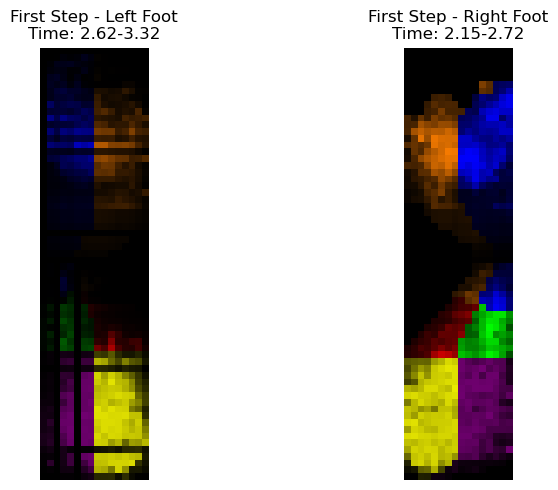

In [50]:
# Determine time ranges for the first step of each foot
first_step_l = gait_events['steps_l'][0]
first_step_r = gait_events['steps_r'][0]

left_start_idx = first_step_l['strike'][0]
left_end_idx   = first_step_l['off'][0] if first_step_l['off'] else first_step_l['strike'][1]
left_start_time = float(t_insole_l[left_start_idx][0])
left_end_time   = float(t_insole_l[left_end_idx][0])
left_time_range = (left_start_time, left_end_time)

right_start_idx = first_step_r['strike'][0]
right_end_idx   = first_step_r['off'][0] if first_step_r['off'] else first_step_r['strike'][1]
right_start_time = float(t_insole_r[right_start_idx][0])
right_end_time   = float(t_insole_r[right_end_idx][0])
right_time_range = (right_start_time, right_end_time)

# Build the color-coded images for the first step of each foot with new filepaths
foot_left_img = build_first_step_color_image(
    'data_by_section/021925/walk_2/six/forelat_left.csv',
    'data_by_section/021925/walk_2/six/foremed_left.csv',
    'data_by_section/021925/walk_2/six/midlat_left.csv',
    'data_by_section/021925/walk_2/six/midmed_left.csv',
    'data_by_section/021925/walk_2/six/hindlat_left.csv',
    'data_by_section/021925/walk_2/six/hindmed_left.csv',
    region_colors,
    left_time_range,
    is_right_foot=False
)

foot_right_img = build_first_step_color_image(
    'data_by_section/021925/walk_2/six/forelat_right.csv',
    'data_by_section/021925/walk_2/six/foremed_right.csv',
    'data_by_section/021925/walk_2/six/midlat_right.csv',
    'data_by_section/021925/walk_2/six/midmed_right.csv',
    'data_by_section/021925/walk_2/six/hindlat_right.csv',
    'data_by_section/021925/walk_2/six/hindmed_right.csv',
    region_colors,
    right_time_range,
    is_right_foot=True
)

# --- Plot the color-coded foot images side by side ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(foot_left_img, origin='upper')
plt.title(f"First Step - Left Foot\nTime: {left_time_range[0]:.2f}-{left_time_range[1]:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.fliplr(foot_right_img), origin='upper')
plt.title(f"First Step - Right Foot\nTime: {right_time_range[0]:.2f}-{right_time_range[1]:.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()

# Dividing by muscles

## Drawing boundary lines

In [280]:
# Part 1: Define functions for drawing boundary lines
def get_extreme_points_from_foot_mask(agg_mask):
    """
    Extract extreme points from an aggregated foot mask.
    Returns foot_top, foot_bot, rows, cols for further processing.
    """
    rows, cols = np.where(agg_mask)
    if len(rows) == 0:
        return None, None, None, None
    
    foot_top = rows.min()
    foot_bot = rows.max()
    
    return foot_top, foot_bot, rows, cols

def get_extreme_points_top(rows, cols, foot_top, n=15):
    """
    Extracts the (x, y) coordinates of the left‑most and right‑most points
    in the top section defined by rows [foot_top, foot_top + n).
    """
    mask_top_section = (rows >= foot_top) & (rows < foot_top + n)
    front_rows = rows[mask_top_section]
    front_cols = cols[mask_top_section]
    
    if len(front_rows) == 0:
        return (0, foot_top), (15, foot_top)  # Default fallback
        
    leftmost_index = np.argmin(front_cols)
    leftmost_point = (front_cols[leftmost_index], front_rows[leftmost_index])
    rightmost_index = np.argmax(front_cols)
    rightmost_point = (front_cols[rightmost_index], front_rows[rightmost_index])
    return leftmost_point, rightmost_point

def get_extreme_points_bottom(rows, cols, foot_bottom, pressure_img, n=10, min_pressure=0.5):
    """
    Extracts the (x, y) coordinates of the left‑most and right‑most points
    in the bottom section defined by rows (foot_bottom - n, foot_bottom].
    """
    mask_bottom_section = (rows <= foot_bottom) & (rows > foot_bottom - n)
    bottom_rows = rows[mask_bottom_section]
    bottom_cols = cols[mask_bottom_section]
    
    if len(bottom_rows) == 0:
        return (0, foot_bottom), (15, foot_bottom)  # Default fallback
    
    # If pressure image is provided, filter by pressure
    if pressure_img is not None:
        pressure_values = pressure_img[bottom_rows, bottom_cols]
        valid_mask = pressure_values >= min_pressure
        bottom_rows = bottom_rows[valid_mask]
        bottom_cols = bottom_cols[valid_mask]
    
    if len(bottom_rows) == 0:
        return (0, foot_bottom), (15, foot_bottom)  # Default fallback
        
    leftmost_index = np.argmin(bottom_cols)
    leftmost_point = (bottom_cols[leftmost_index], bottom_rows[leftmost_index])
    rightmost_index = np.argmax(bottom_cols)
    rightmost_point = (bottom_cols[rightmost_index], bottom_rows[rightmost_index])
    return leftmost_point, rightmost_point

def divide_line(A, B, t):
    """Returns the point along the line from A to B at fraction t."""
    return (A[0] + t * (B[0] - A[0]), A[1] + t * (B[1] - A[1]))

def shrink_line(A, B, shrink_factor=0.8):
    """
    Returns new endpoints for the line segment from A to B shrunk to shrink_factor times
    its original length, while keeping the segment centered.
    """
    M = ((A[0] + B[0]) / 2.0, (A[1] + B[1]) / 2.0)
    A_shrunk = (M[0] - (shrink_factor/2.0) * (B[0] - A[0]),
               M[1] - (shrink_factor/2.0) * (B[1] - A[1]))
    B_shrunk = (M[0] + (shrink_factor/2.0) * (B[0] - A[0]),
               M[1] + (shrink_factor/2.0) * (B[1] - A[1]))
    return A_shrunk, B_shrunk

def divide_bottom_line(foot_side, bot_left, bot_right):
    """
    For the bottom of the foot, using the extreme points bot_left and bot_right,
    first shrink the line connecting them to 80% of its original length.
    Then divide that shrunken line into segments in a 3.6:7:2 ratio.
    """
    if foot_side == "left":
        A = bot_right  # rightmost bottom point
        B = bot_left   # leftmost bottom point
    elif foot_side == "right":
        A = bot_left   # leftmost bottom point
        B = bot_right  # rightmost bottom point
    else:
        raise ValueError("foot_side must be either 'left' or 'right'")
    
    A_shrunk, B_shrunk = shrink_line(A, B, shrink_factor=0.8)
    total_parts = 3.6 + 7 + 2  # 12.6 parts
    t1 = 3.6 / total_parts      # ≈0.2857
    t2 = (3.6 + 7) / total_parts  # ≈0.8413
    div1 = divide_line(A_shrunk, B_shrunk, t1)
    div2 = divide_line(A_shrunk, B_shrunk, t2)
    return div1, div2

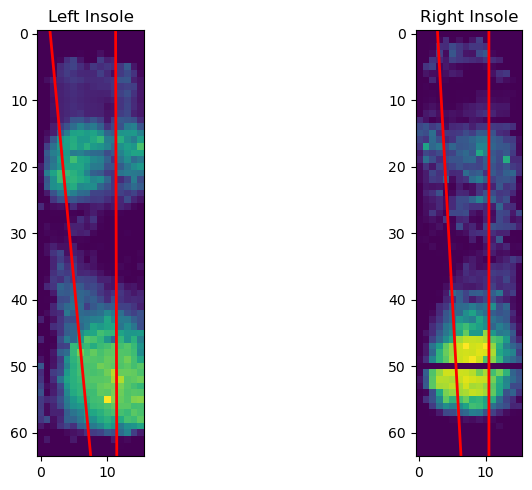

In [281]:
# Segmenting based on muscles (2:5:1)
# Get extreme top points
left_top_left, left_top_right = get_extreme_points_top(rows_l, cols_l, foot_top_l, n=10)
right_top_left, right_top_right = get_extreme_points_top(rows_r, cols_r, foot_top_r, n=10)

# Get extreme bottom points (with pressure filtering; adjust min_pressure as needed)
left_bot_left, left_bot_right = get_extreme_points_bottom(rows_l, cols_l, foot_bot_l, img_avg_l, n=10, min_pressure=300)
right_bot_left, right_bot_right = get_extreme_points_bottom(rows_r, cols_r, foot_bot_r, img_avg_r, n=10, min_pressure=300)

# Divide the top line using a 2:5:1 ratio
# For the right foot (division from left to right)
right_A_top = right_top_left
right_B_top = right_top_right
right_top_div1 = divide_line(right_A_top, right_B_top, 2/8)  # left divider point
right_top_div2 = divide_line(right_A_top, right_B_top, 7/8)  # right divider point
# For the left foot (division from right to left)
left_A_top = left_top_right
left_B_top = left_top_left
left_top_div1 = divide_line(left_A_top, left_B_top, 2/8)   # right divider point
left_top_div2 = divide_line(left_A_top, left_B_top, 7/8)   # left divider point

# Divide the bottom line using a 3.6:7:2 ratio (after shrinking)
# For the right foot (division from left to right)
right_bot_div1, right_bot_div2 = divide_bottom_line("right", right_bot_left, right_bot_right)
# For the left foot (division from right to left):
left_bot_div1, left_bot_div2 = divide_bottom_line("left", left_bot_left, left_bot_right)

# Draw two lines through each foot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_avg_l)
axs[0].set_title("Left Insole")
axs[1].imshow(img_avg_r)
axs[1].set_title("Right Insole")

# Draw infinite red lines using ax.axline:
axs[0].axline(left_top_div2, left_bot_div2, color='r', linewidth=2)  # left side for left foot
axs[0].axline(left_top_div1, left_bot_div1, color='r', linewidth=2)  # right side for left foot

axs[1].axline(right_top_div1, right_bot_div1, color='r', linewidth=2)  # left side for right foot
axs[1].axline(right_top_div2, right_bot_div2, color='r', linewidth=2)  # right side for right foot

plt.tight_layout()
plt.show()

## Assigning datapoints based on boundaries

In [282]:
# Part 3: Define functions for assigning points to sections
def side_of_line(ptA, ptB, ptP):
    """
    Returns the 2D cross product of (ptB - ptA) and (ptP - ptA).
    > 0 => ptP is to the "left" of the directed line A->B
    < 0 => ptP is to the "right" of A->B
    = 0 => ptP is exactly on the line
    """
    return ((ptB[0] - ptA[0]) * (ptP[1] - ptA[1])
            - (ptB[1] - ptA[1]) * (ptP[0] - ptA[0]))

def build_first_step_color_image(csv_lateral_or_medial, csv_midline, csv_medial_or_lateral, region_colors, step_time_range, is_left_foot=True):
    """
    Reads three CSV files for a single foot, filters for data only from the first step, 
    and returns a color-coded image.
    
    For left foot: csv_lateral_or_medial=lateral, csv_medial_or_lateral=medial
    For right foot: csv_lateral_or_medial=medial, csv_medial_or_lateral=lateral
    """
    # 1) Load each CSV
    df_lateral_or_medial = pd.read_csv(csv_lateral_or_medial)
    df_midline = pd.read_csv(csv_midline)
    df_medial_or_lateral = pd.read_csv(csv_medial_or_lateral)
    
    # 2) Filter for data only from the first step
    start_time, end_time = float(step_time_range[0]), float(step_time_range[1])
    df_lateral_or_medial = df_lateral_or_medial[(df_lateral_or_medial['timestamp'] >= start_time) & 
                                               (df_lateral_or_medial['timestamp'] <= end_time)]
    df_midline = df_midline[(df_midline['timestamp'] >= start_time) & 
                           (df_midline['timestamp'] <= end_time)]
    df_medial_or_lateral = df_medial_or_lateral[(df_medial_or_lateral['timestamp'] >= start_time) & 
                                              (df_medial_or_lateral['timestamp'] <= end_time)]
    
    # 3) Group by (row, col) => mean pressure
    group_lateral_or_medial = df_lateral_or_medial.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_midline = df_midline.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_medial_or_lateral = df_medial_or_lateral.groupby(['row', 'col'])['pressure'].mean().reset_index()
    
    # 4) Determine a global max for intensity scaling
    max_pressure = max(
        group_lateral_or_medial['pressure'].max() if not group_lateral_or_medial.empty else 0,
        group_midline['pressure'].max() if not group_midline.empty else 0,
        group_medial_or_lateral['pressure'].max() if not group_medial_or_lateral.empty else 0
    )
    if max_pressure == 0:
        max_pressure = 1  # Avoid division by zero
    
    # 5) Build an empty color image (64 x 16 x 3)
    foot_img = np.zeros((64, 16, 3), dtype=float)
    
    # Helper to fill in region with color proportional to pressure
    def fill_region(df_group, color):
        for idx, row_data in df_group.iterrows():
            r = int(row_data['row'])
            c = int(row_data['col'])
            val = row_data['pressure']
            
            intensity = val / max_pressure
            foot_img[r, c, :] = color * intensity
    
    # 6) Fill each region with its color
    if is_left_foot:
        # For left foot: lateral, midline, medial
        fill_region(group_lateral_or_medial, region_colors['lateral'])
        fill_region(group_midline, region_colors['midline'])
        fill_region(group_medial_or_lateral, region_colors['medial'])
    else:
        # For right foot: medial, midline, lateral
        fill_region(group_lateral_or_medial, region_colors['medial'])
        fill_region(group_midline, region_colors['midline'])
        fill_region(group_medial_or_lateral, region_colors['lateral'])
    
    return foot_img

In [283]:
# Part 4: Assign points to sections and save to CSV
# Define line endpoints for section assignments
# LEFT FOOT lines:
Lline_lateral_top = left_top_div2
Lline_lateral_bottom = left_bot_div2
Lline_medial_top = left_top_div1
Lline_medial_bottom = left_bot_div1
# RIGHT FOOT lines:
Rline_medial_top = right_top_div1
Rline_medial_bottom = right_bot_div1
Rline_lateral_top = right_top_div2
Rline_lateral_bottom = right_bot_div2

# Initialize data lists for each section
left_foot_lateral_data = []
left_foot_midline_data = []
left_foot_medial_data = []
right_foot_medial_data = []
right_foot_midline_data = []
right_foot_lateral_data = []

# Get total frames
N_left = insoleAll_l.shape[0]
N_right = insoleAll_r.shape[0]

# Loop over each time frame for the LEFT foot
for i in range(N_left):
    t_l_i = float(t_insole_l[i][0])  # Timestamp for this frame (extract scalar value)
    frame_l = np.reshape(insoleAll_l[i, :], (64, 16), order='F')
    frame_l[:32, :] = np.flipud(frame_l[:32, :])  # Flip top half as in original code
    
    for row in range(64):
        for col in range(16):
            pressure_val = frame_l[row, col]
            # Skip near-zero pressure points to reduce file size
            if pressure_val < 1:
                continue
                
            P = (col, row)  # (x, y)
            side_lateral = side_of_line(Lline_lateral_top, Lline_lateral_bottom, P)
            side_medial = side_of_line(Lline_medial_top, Lline_medial_bottom, P)
            
            if side_lateral > 0:
                # Pixel is "left" of lateral boundary => lateral section
                left_foot_lateral_data.append([t_l_i, row, col, pressure_val])
            elif side_medial < 0:
                # Pixel is "right" of medial boundary => medial section
                left_foot_medial_data.append([t_l_i, row, col, pressure_val])
            else:
                # Otherwise, it's in the midline
                left_foot_midline_data.append([t_l_i, row, col, pressure_val])

# Loop over each time frame for the RIGHT foot
for i in range(N_right):
    t_r_i = float(t_insole_r[i][0])  # Timestamp for this frame (extract scalar value)
    frame_r = np.reshape(insoleAll_r[i, :], (64, 16), order='F')
    frame_r = np.fliplr(frame_r)  # Flip left-right for right foot
    frame_r[:32, :] = np.flipud(frame_r[:32, :])  # Flip top half
    
    for row in range(64):
        for col in range(16):
            pressure_val = frame_r[row, col]
            # Skip near-zero pressure points to reduce file size
            if pressure_val < 1:
                continue
                
            P = (col, row)
            side_medial = side_of_line(Rline_medial_top, Rline_medial_bottom, P)
            side_lateral = side_of_line(Rline_lateral_top, Rline_lateral_bottom, P)
            
            if side_medial > 0:
                right_foot_medial_data.append([t_r_i, row, col, pressure_val])
            elif side_lateral < 0:
                right_foot_lateral_data.append([t_r_i, row, col, pressure_val])
            else:
                right_foot_midline_data.append([t_r_i, row, col, pressure_val])

# Create and save DataFrames
cols = ["timestamp", "row", "col", "pressure"]
df_left_foot_lateral = pd.DataFrame(left_foot_lateral_data, columns=cols)
df_left_foot_midline = pd.DataFrame(left_foot_midline_data, columns=cols)
df_left_foot_medial = pd.DataFrame(left_foot_medial_data, columns=cols)
df_right_foot_medial = pd.DataFrame(right_foot_medial_data, columns=cols)
df_right_foot_midline = pd.DataFrame(right_foot_midline_data, columns=cols)
df_right_foot_lateral = pd.DataFrame(right_foot_lateral_data, columns=cols)

# Ensure timestamps are the right type
df_left_foot_lateral['timestamp'] = df_left_foot_lateral['timestamp'].astype('float64')
df_left_foot_midline['timestamp'] = df_left_foot_midline['timestamp'].astype('float64')
df_left_foot_medial['timestamp'] = df_left_foot_medial['timestamp'].astype('float64')
df_right_foot_medial['timestamp'] = df_right_foot_medial['timestamp'].astype('float64')
df_right_foot_midline['timestamp'] = df_right_foot_midline['timestamp'].astype('float64')
df_right_foot_lateral['timestamp'] = df_right_foot_lateral['timestamp'].astype('float64')

# Save to CSV files
df_left_foot_lateral.to_csv("data_by_section/GAIT080624-01/walk_4/muscle/left_foot_lateral.csv", index=False)
df_left_foot_midline.to_csv("data_by_section/GAIT080624-01/walk_4/muscle/left_foot_midline.csv", index=False)
df_left_foot_medial.to_csv("data_by_section/GAIT080624-01/walk_4/muscle/left_foot_medial.csv", index=False)
df_right_foot_medial.to_csv("data_by_section/GAIT080624-01/walk_4/muscle/right_foot_medial.csv", index=False)
df_right_foot_midline.to_csv("data_by_section/GAIT080624-01/walk_4/muscle/right_foot_midline.csv", index=False)
df_right_foot_lateral.to_csv("data_by_section/GAIT080624-01/walk_4/muscle/right_foot_lateral.csv", index=False)

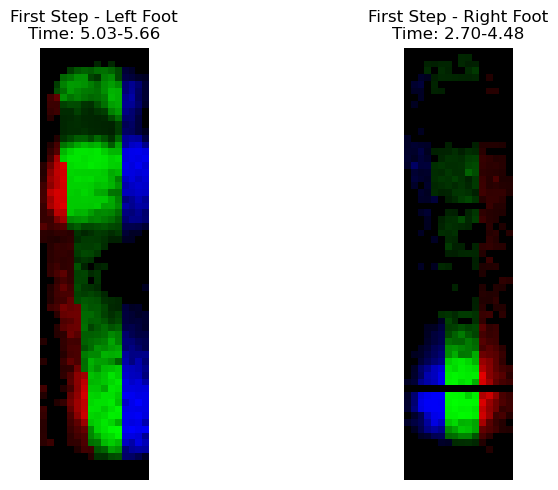

In [284]:
# Part 5: Plot the first step for visualization
# Get time ranges for first steps
# We already have first_step_l and first_step_r from earlier

# Get start and end time for the first left step
left_start_idx = first_step_l['strike'][0]
left_end_idx = first_step_l['off'][0] if first_step_l['off'] else first_step_l['strike'][1]
left_start_time = float(t_insole_l[left_start_idx][0])
left_end_time = float(t_insole_l[left_end_idx][0])
left_time_range = (left_start_time, left_end_time)

# Get start and end time for the first right step
right_start_idx = first_step_r['strike'][0]
right_end_idx = first_step_r['off'][0] if first_step_r['off'] else first_step_r['strike'][1]
right_start_time = float(t_insole_r[right_start_idx][0])
right_end_time = float(t_insole_r[right_end_idx][0])
right_time_range = (right_start_time, right_end_time)

# Define region colors
region_colors = {
    'lateral': np.array([1.0, 0.0, 0.0]),  # Red
    'midline': np.array([0.0, 1.0, 0.0]),  # Green
    'medial': np.array([0.0, 0.0, 1.0])    # Blue
}

# Build the color-coded images for first step of left and right feet
foot_left_img = build_first_step_color_image(
    'data_by_section/GAIT080624-01/walk_4/muscle/left_foot_lateral.csv',
    'data_by_section/GAIT080624-01/walk_4/muscle/left_foot_midline.csv',
    'data_by_section/GAIT080624-01/walk_4/muscle/left_foot_medial.csv',
    region_colors,
    left_time_range,
    is_left_foot=True
)

foot_right_img = build_first_step_color_image(
    'data_by_section/GAIT080624-01/walk_4/muscle/right_foot_medial.csv',
    'data_by_section/GAIT080624-01/walk_4/muscle/right_foot_midline.csv',
    'data_by_section/GAIT080624-01/walk_4/muscle/right_foot_lateral.csv',
    region_colors,
    right_time_range,
    is_left_foot=False
)

# Plot side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(foot_left_img, origin='upper')
plt.title(f"First Step - Left Foot\nTime: {left_time_range[0]:.2f}-{left_time_range[1]:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(foot_right_img, origin='upper')
plt.title(f"First Step - Right Foot\nTime: {right_time_range[0]:.2f}-{right_time_range[1]:.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()

# Dividing by nerves

## Drawing boundary lines

In [288]:
# Part 1: Define helper functions for nerve distribution
def get_point_in_row(row_idx, foot_mask, fraction=0.25):
    """
    For the given row_idx, find all columns where foot_mask[row_idx, col] == True.
    Then return (x, y) = (col, row_idx) at the specified fraction
    between the leftmost and rightmost columns.
    Example: fraction=0.25 => 1:3 ratio from leftmost to rightmost.
    """
    cols_in_row = np.where(foot_mask[row_idx, :])[0]
    if len(cols_in_row) == 0:
        return None  # No foot data in this row

    leftmost = cols_in_row.min()
    rightmost = cols_in_row.max()

    # The fraction of the way from leftmost to rightmost
    x = leftmost + fraction * (rightmost - leftmost)
    return (x, row_idx)


def get_boundary_points(foot_side, foot_mask, foot_top, foot_bot):
    """
    Returns two points:
      p1 = 1:3 ratio in the '10th row' from the top
      p2 = midpoint (1:1) in the row at 5/8 of the height from top to bottom
    Invert the fraction for the 1:3 ratio if foot_side == 'right'.
    """
    # "10th row" from top (0-based means add 9)
    row_10 = foot_top #+ 9

    # 5/8 down from top
    row_5_8 = int(foot_top + (5/8)*(foot_bot - foot_top))

    # For left foot => fraction=0.25 (1:3 ratio from left to right)
    # For right foot => fraction=0.75 (inverted)
    if foot_side.lower() == "left":
        frac_1_3 = 0.25
    else:
        frac_1_3 = 0.75

    p1 = get_point_in_row(row_10, foot_mask, fraction=frac_1_3)
    # p2 = midpoint => fraction=0.5
    p2 = get_point_in_row(row_5_8, foot_mask, fraction=0.5)

    return p1, p2

def draw_line_one_sided(ax, p_start, p_end, color='r'):
    """
    Parametric form:
       p(t) = p_start + t*(d),  where d = (p_end - p_start).
    We want t from 0 to tmax, so p(0)=p_start, p(1)=p_end (inside line),
    and the line extends beyond t=1 until it hits boundary, but
    does NOT go below p(0).

    bounding box: x in [0,15], y in [0,63].
    """
    if p_start is None or p_end is None:
        return
    
    x0, y0 = p_start
    x1, y1 = p_end
    dx = x1 - x0
    dy = y1 - y0

    tmin, tmax = 0.0, float('inf')  # We'll keep t >= 0
    # handle x
    if abs(dx) > 1e-9:
        if dx > 0:
            # t in [ -x0/dx, (15 - x0)/dx ]
            left = -x0/dx
            right = (15 - x0)/dx
        else:
            # dx < 0
            left = (15 - x0)/dx
            right = -x0/dx
        # intersection with [0,∞):
        lower_bound = max(0, left)
        upper_bound = min(right, float('inf'))
        tmin = max(tmin, lower_bound)
        tmax = min(tmax, upper_bound)

    # handle y
    if abs(dy) > 1e-9:
        if dy > 0:
            # t in [ -y0/dy, (63 - y0)/dy ]
            left = -y0/dy
            right = (63 - y0)/dy
        else:
            # dy < 0
            left = (63 - y0)/dy
            right = -y0/dy
        # intersection with [0,∞)
        lower_bound = max(0, left)
        upper_bound = min(right, float('inf'))
        tmin = max(tmin, lower_bound)
        tmax = min(tmax, upper_bound)
    else:
        # dy=0 => no additional constraint on y
        pass

    if tmax < tmin:
        # no valid intersection; no line
        return
    
    # We'll draw from t=0 to t=tmax
    xA = x0 + tmin*dx
    yA = y0 + tmin*dy
    xB = x0 + tmax*dx
    yB = y0 + tmax*dy

    # Just to ensure we are inside the bounding box
    xA, yA = max(0, min(15, xA)), max(0, min(63, yA))
    xB, yB = max(0, min(15, xB)), max(0, min(63, yB))

    ax.plot([xA, xB], [yA, yB], color=color, linewidth=2)

def draw_45_deg_branches(ax, point, length=10, color='g'):
    """
    Draws two short 45° line segments ("V" shape) downward from 'point'.
    In row-column coords, "down" means increasing y.
    We'll define one branch with slope ~ +1, the other ~ -1.
    """
    if point is None:
        return
        
    x0, y0 = point

    # Left-branch: (x0 - length, y0 + length)
    x_left = x0 - length
    y_down_left = y0 + length

    # Right-branch: (x0 + length, y0 + length)
    x_right = x0 + length
    y_down_right = y0 + length

    ax.plot([x0, x_left], [y0, y_down_left], color=color, linewidth=2)
    ax.plot([x0, x_right], [y0, y_down_right], color=color, linewidth=2)

def get_45_end_right_edge(p2):
    """
    For slope = +1, param is:
       x(t) = x2 + t,   y(t) = y2 + t
    We solve for x(t)=15 => t = 15 - x2.
    Then y(t)=y2 + (15 - x2). If that exceeds 63, clamp y=63.
    Returns the intersection point (x_end, y_end).
    """
    if p2 is None:
        return None
        
    x2, y2 = p2
    # Solve t = 15 - x2
    t = 15 - x2
    if t < 0:
        # Means p2 is already beyond the right edge or no valid intersection
        return None
    y_end = y2 + t
    # Clamp to y=63 if needed
    if y_end > 63:
        y_end = 63
    return (15, y_end)


def get_45_end_left_edge(p2):
    """
    For slope = -1, param is:
       x(t) = x2 - t,   y(t) = y2 + t
    We solve x(t)=0 => t = x2.
    Then y(t)=y2 + x2. If that exceeds 63, clamp y=63.
    Returns (0, y_end).
    """
    if p2 is None:
        return None
        
    x2, y2 = p2
    t = x2
    if t < 0:
        # Means p2 is left of x=0 or no valid intersection
        return None
    y_end = y2 + t
    if y_end > 63:
        y_end = 63
    return (0, y_end)


def draw_curve(ax, start_pt, end_pt, shift, color='m'):
    """
    Draw a strongly curved line from start_pt to end_pt by adding
    a horizontal 'shift * t(1 - t)' term.
    - If 'shift' < 0, the curve bows left.
    - If 'shift' > 0, the curve bows right.
    """
    if (start_pt is None) or (end_pt is None):
        return
    x0, y0 = start_pt
    x1, y1 = end_pt
    
    t_vals = np.linspace(0, 1, 50)  # 50 points for smoother curve
    
    # x: linear interpolation plus a "shift * t*(1-t)" offset
    x_curve = (1 - t_vals)*x0 + t_vals*x1 + shift * t_vals*(1 - t_vals)
    # y: just linear interpolation
    y_curve = (1 - t_vals)*y0 + t_vals*y1
    
    ax.plot(x_curve, y_curve, color=color, linewidth=2)
    
def side_of_line(ptA, ptB, ptP):
    """
    Returns the 2D cross product of (ptB - ptA) and (ptP - ptA).
    > 0 => ptP is to the "left" of the directed line A->B
    < 0 => ptP is to the "right" of A->B
    = 0 => ptP is exactly on the line
    """
    return ((ptB[0] - ptA[0]) * (ptP[1] - ptA[1])
            - (ptB[1] - ptA[1]) * (ptP[0] - ptA[0]))

def build_first_step_color_image(csv_lateral, csv_medial, csv_tibial, csv_sural, csv_saphenous, 
                                 region_colors, step_time_range):
    """
    Reads five CSV files for a single foot,
    filters for data only from the first step, and returns a color-coded image.
    """
    # 1) Load each CSV
    df_lateral = pd.read_csv(csv_lateral)
    df_medial = pd.read_csv(csv_medial)
    df_tibial = pd.read_csv(csv_tibial)
    df_sural = pd.read_csv(csv_sural)
    df_saphenous = pd.read_csv(csv_saphenous)
    
    # 2) Filter for data only from the first step
    start_time, end_time = float(step_time_range[0]), float(step_time_range[1])
    df_lateral = df_lateral[(df_lateral['timestamp'] >= start_time) & (df_lateral['timestamp'] <= end_time)]
    df_medial = df_medial[(df_medial['timestamp'] >= start_time) & (df_medial['timestamp'] <= end_time)]
    df_tibial = df_tibial[(df_tibial['timestamp'] >= start_time) & (df_tibial['timestamp'] <= end_time)]
    df_sural = df_sural[(df_sural['timestamp'] >= start_time) & (df_sural['timestamp'] <= end_time)]
    df_saphenous = df_saphenous[(df_saphenous['timestamp'] >= start_time) & (df_saphenous['timestamp'] <= end_time)]
    
    # 3) Group by (row, col) => mean pressure for each region
    group_lateral = df_lateral.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_medial = df_medial.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_tibial = df_tibial.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_sural = df_sural.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_saphenous = df_saphenous.groupby(['row', 'col'])['pressure'].mean().reset_index()
    
    # 4) Determine a global max for intensity scaling
    max_pressure = max(
        group_lateral['pressure'].max() if not group_lateral.empty else 0,
        group_medial['pressure'].max() if not group_medial.empty else 0,
        group_tibial['pressure'].max() if not group_tibial.empty else 0,
        group_sural['pressure'].max() if not group_sural.empty else 0,
        group_saphenous['pressure'].max() if not group_saphenous.empty else 0
    )
    
    if max_pressure == 0:
        max_pressure = 1  # Avoid division by zero
    
    # 5) Build an empty color image (64 x 16 x 3)
    foot_img = np.zeros((64, 16, 3), dtype=float)
    
    # Helper to fill in region with color proportional to pressure
    def fill_region(df_group, color):
        for idx, row_data in df_group.iterrows():
            r = int(row_data['row'])
            c = int(row_data['col'])
            val = row_data['pressure']
            
            intensity = val / max_pressure
            foot_img[r, c, :] = color * intensity
            
    # 6) Fill each region with its color
    fill_region(group_lateral, region_colors['lateral'])
    fill_region(group_medial, region_colors['medial'])
    fill_region(group_tibial, region_colors['tibial'])
    fill_region(group_sural, region_colors['sural'])
    fill_region(group_saphenous, region_colors['saphenous'])
    
    return foot_img

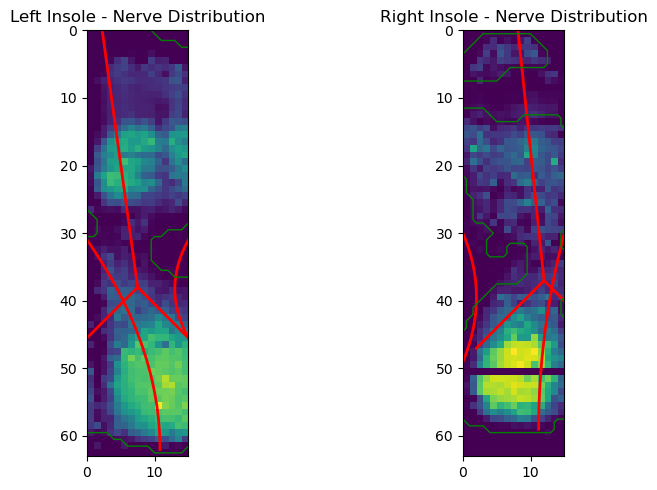

In [289]:
# Part 2 (modified): Extract the foot outlines and determine nerve boundaries
# Get the first step for each foot
first_step_l = gait_events['steps_l'][0]
first_step_r = gait_events['steps_r'][0]

# Get the aggregated mask for the first step of each foot
agg_mask_l = aggregate_mask_central_window(insoleAll_l, first_step_l, 
                                           dim=tunable_params['insole_dims'], 
                                           window=tunable_params['aggregation_window'])
agg_mask_r_flipped = np.fliplr(aggregate_mask_central_window(insoleAll_r, first_step_r, 
                                                            dim=tunable_params['insole_dims'], 
                                                            window=tunable_params['aggregation_window']))

# Find the topmost and bottommost row indices where the foot has data
rows_l, cols_l = np.nonzero(agg_mask_l)
rows_r, cols_r = np.nonzero(agg_mask_r_flipped)
foot_top_l = rows_l.min()
foot_bot_l = rows_l.max()
foot_top_r = rows_r.min()
foot_bot_r = rows_r.max()

# Determine boundary points for nerve distribution
left_p1, left_p2 = get_boundary_points("left", agg_mask_l, foot_top_l, foot_bot_l)
right_p1, right_p2 = get_boundary_points("right", agg_mask_r_flipped, foot_top_r, foot_bot_r)

# Plotting the nerve boundaries
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# LEFT FOOT
axs[0].imshow(img_avg_l, origin='upper', cmap='viridis', extent=[0, 16, 64, 0])
axs[0].set_xlim(0, 15)
axs[0].set_ylim(63, 0)
axs[0].set_title("Left Insole - Nerve Distribution")

# Draw the dividing lines
if left_p1 and left_p2:
    # Draw main division line
    draw_line_one_sided(axs[0], p_start=left_p2, p_end=left_p1, color='r')
    
    # Draw 45° branches
    draw_45_deg_branches(axs[0], left_p2, color='r')

# RIGHT FOOT
axs[1].imshow(img_avg_r, origin='upper', cmap='viridis', extent=[0, 16, 64, 0])
axs[1].set_xlim(0, 15)
axs[1].set_ylim(63, 0)
axs[1].set_title("Right Insole - Nerve Distribution")

if right_p1 and right_p2:
    # Draw main division line
    draw_line_one_sided(axs[1], p_start=right_p2, p_end=right_p1, color='r')
    
    # Draw 45° branches
    draw_45_deg_branches(axs[1], right_p2, color='r')

# Define new 'effective' bottom rows
foot_bot_eff_l = foot_bot_l
foot_bot_eff_r = foot_bot_r

# Extend sural curve all the way to the edge of the foot for both feet
# LEFT FOOT
row_mid_l = (foot_top_l + foot_bot_l) // 2
x_start_l = 0
y_start_l = row_mid_l
cols_bot_l = np.where(agg_mask_l[foot_bot_l, :])[0]

if len(cols_bot_l) > 0:
    x_left_bot_l = cols_bot_l.min()
    x_right_bot_l = cols_bot_l.max()
    # 1/5 from the LEFT side => fraction=0.2
    x_target_l = x_left_bot_l + 0.2 * (x_right_bot_l - x_left_bot_l)
    t_vals = np.linspace(0, 1, 30)
    # Curve from midpoint to bottom edge
    x_curve_l = x_start_l + (x_target_l - x_start_l) * (1 - (1 - t_vals)**2)
    y_curve_l = y_start_l + (foot_bot_l - y_start_l) * t_vals
    axs[0].plot(x_curve_l, y_curve_l, 'r-', linewidth=2)
    
    # Extend a vertical line from the curve endpoint to the foot bottom
    if foot_bot_l > y_curve_l[-1]:
        axs[0].plot([x_curve_l[-1], x_curve_l[-1]], [y_curve_l[-1], foot_bot_l], 'r-', linewidth=2)

# RIGHT FOOT
row_mid_r = (foot_top_r + foot_bot_r) // 2
x_start_r = 15
y_start_r = row_mid_r
cols_bot_r = np.where(agg_mask_r_flipped[foot_bot_r, :])[0]

if len(cols_bot_r) > 0:
    x_left_bot_r = cols_bot_r.min()
    x_right_bot_r = cols_bot_r.max()
    # "1/5 from the right" => fraction=0.8 from the left edge
    x_target_r = x_left_bot_r + 0.8 * (x_right_bot_r - x_left_bot_r)
    t_vals = np.linspace(0, 1, 30)
    x_curve_r = x_start_r + (x_target_r - x_start_r) * (1 - (1 - t_vals)**2)
    y_curve_r = y_start_r + (foot_bot_r - y_start_r) * t_vals
    axs[1].plot(x_curve_r, y_curve_r, 'r-', linewidth=2)
    
    # Extend a vertical line from the curve endpoint to the foot bottom
    if foot_bot_r > y_curve_r[-1]:
        axs[1].plot([x_curve_r[-1], x_curve_r[-1]], [y_curve_r[-1], foot_bot_r], 'r-', linewidth=2)

# Saphenous nerve curve - LEFT FOOT
p_start_l = (15, row_mid_l)  # Right edge, midpoint row
p_end_l = get_45_end_right_edge(left_p2)  # Intersection with x=15 from left_p2's +45 line
draw_curve(axs[0], p_start_l, p_end_l, shift=-8, color='r')

# Saphenous nerve curve - RIGHT FOOT
p_start_r = (0, row_mid_r)  # Left edge, midpoint row
p_end_r = get_45_end_left_edge(right_p2)  # Intersection with x=0 from right_p2's -45 line
draw_curve(axs[1], p_start_r, p_end_r, shift=8, color='r')

# Draw foot outlines
for contour in find_contours(agg_mask_l, level=0.5):
    axs[0].plot(contour[:, 1], contour[:, 0], 'g', linewidth=1)
for contour in find_contours(agg_mask_r_flipped, level=0.5):
    axs[1].plot(contour[:, 1], contour[:, 0], 'g', linewidth=1)

plt.tight_layout()
plt.show()

# Define y_end values for the saphenous nerve
if p_end_l is not None:
    y_end_l = p_end_l[1]
else:
    y_end_l = foot_bot_eff_l

if p_end_r is not None:
    y_end_r = p_end_r[1]
else:
    y_end_r = foot_bot_eff_r

## Assigning datapoints based on boundaries

In [290]:
# Part 3 (Modified): Assign points to nerve regions and save to CSV
pressure_threshold = 1  # Minimum pressure to consider

# Initialize data lists for each region
left_foot_lateral_plantar_data = []  # lateral plantar
left_foot_medial_plantar_data = []   # medial plantar
left_foot_tibial_data = []           # tibial
left_foot_sural_data = []            # sural
left_foot_saphenous_data = []        # saphenous

right_foot_lateral_plantar_data = [] # anatomically lateral (right)
right_foot_medial_plantar_data = []  # anatomically medial (left)
right_foot_tibial_data = []
right_foot_sural_data = []
right_foot_saphenous_data = []

# Process LEFT FOOT data
N_left = insoleAll_l.shape[0]

for i in range(N_left):
    t_l = float(t_insole_l[i][0])  # Extract scalar timestamp
    # Reshape the flat vector into a 64x16 image (order='F')
    frame_l = np.reshape(insoleAll_l[i, :], (64, 16), order='F')
    frame_l[:32, :] = np.flipud(frame_l[:32, :])  # Flip top half
    
    for row in range(64):
        for col in range(16):
            pressure_val = frame_l[row, col]
            # Skip low-pressure readings
            if pressure_val < pressure_threshold:
                continue
                
            P = (col, row)  # (x, y)
            
            # --- Step 1: Dividing line ---
            # For left foot, "lateral" is to the left of the line from p2 to p1
            side_div = side_of_line(left_p2, left_p1, P)
            
            # --- Step 2: 45° branch lines (from left_p2) ---
            y_left_branch = -col + (left_p2[0] + left_p2[1])
            y_right_branch = col + (left_p2[1] - left_p2[0])
            
            # --- Step 3: Upper and Lower Regions ---
            # Calculate the sural and saphenous boundaries
            if (row >= row_mid_l) and (row <= foot_bot_l):
                t_val = (row - row_mid_l) / (foot_bot_l - row_mid_l)
                x_sural = (x_target_l) * (1 - (1 - t_val)**2)
            else:
                x_sural = -np.inf
                
            if (row >= row_mid_l) and (row <= y_end_l):
                t_val = (row - row_mid_l) / (y_end_l - row_mid_l)
                x_saph = 15 - 8 * t_val * (1 - t_val)
            else:
                x_saph = np.inf
            
            # Upper region (above the 45° branches)
            if (row < y_left_branch) and (row < y_right_branch):
                if side_div > 0:
                    # Left of the main dividing line
                    if col < x_sural:
                        region = "sural"  # Lateral (left) of sural line
                    else:
                        region = "lateral plantar"
                elif side_div < 0:
                    # Right of the main dividing line
                    if col > x_saph:
                        region = "saphenous"  # Right of saphenous line
                    else:
                        region = "medial plantar"
                else:
                    region = None
            # Lower region
            else:
                if col < x_sural:
                    region = "sural"  # Lateral (left) of sural line
                elif col > x_saph:
                    region = "saphenous"  # Right of saphenous line
                else:
                    region = "tibial"
            
            # --- Step 4: Append sensor reading to the corresponding list ---
            if region == "lateral plantar":
                left_foot_lateral_plantar_data.append([t_l, row, col, pressure_val])
            elif region == "medial plantar":
                left_foot_medial_plantar_data.append([t_l, row, col, pressure_val])
            elif region == "tibial":
                left_foot_tibial_data.append([t_l, row, col, pressure_val])
            elif region == "sural":
                left_foot_sural_data.append([t_l, row, col, pressure_val])
            elif region == "saphenous":
                left_foot_saphenous_data.append([t_l, row, col, pressure_val])

# Process RIGHT FOOT data
N_right = insoleAll_r.shape[0]

for i in range(N_right):
    t_r = float(t_insole_r[i][0])  # Extract scalar timestamp
    frame_r = np.reshape(insoleAll_r[i, :], (64, 16), order='F')
    frame_r = np.fliplr(frame_r)  # Flip left-right
    frame_r[:32, :] = np.flipud(frame_r[:32, :])  # Flip top half
    
    for row in range(64):
        for col in range(16):
            pressure_val = frame_r[row, col]
            if pressure_val < pressure_threshold:
                continue
                
            P = (col, row)
            
            # Use right_p2 and right_p1 for the dividing line
            side_div = side_of_line(right_p2, right_p1, P)
            
            # 45° branch lines (from right_p2)
            y_left_branch = -col + (right_p2[0] + right_p2[1])
            y_right_branch = col + (right_p2[1] - right_p2[0])
            
            # Calculate the sural and saphenous boundaries
            if (row >= row_mid_r) and (row <= foot_bot_r):
                t_val = (row - row_mid_r) / (foot_bot_r - row_mid_r)
                # For right foot, sural on the right side
                x_sural = x_target_r + (15 - x_target_r) * (1 - (1 - t_val)**2)
            else:
                x_sural = np.inf
                
            if (row >= row_mid_r) and (row <= y_end_r):
                t_val = (row - row_mid_r) / (y_end_r - row_mid_r)
                # For right foot, saphenous on the left side
                x_saph = 8 * t_val * (1 - t_val)
            else:
                x_saph = -np.inf
            
            # Upper region (above the 45° branches)
            if (row < y_left_branch) and (row < y_right_branch):
                if side_div > 0:
                    # Left of the main dividing line
                    if col < x_saph:
                        region = "saphenous"  # Left of saphenous line
                    else:
                        region = "medial plantar"
                elif side_div < 0:
                    # Right of the main dividing line
                    if col > x_sural:
                        region = "sural"  # Right of sural line
                    else:
                        region = "lateral plantar"
                else:
                    region = None
            # Lower region
            else:
                if col > x_sural:
                    region = "sural"  # Right of sural line = sural region
                elif col < x_saph:
                    region = "saphenous"  # Left of saphenous line
                else:
                    region = "tibial"
            
            if region == "lateral plantar":
                right_foot_lateral_plantar_data.append([t_r, row, col, pressure_val])
            elif region == "medial plantar":
                right_foot_medial_plantar_data.append([t_r, row, col, pressure_val])
            elif region == "tibial":
                right_foot_tibial_data.append([t_r, row, col, pressure_val])
            elif region == "sural":
                right_foot_sural_data.append([t_r, row, col, pressure_val])
            elif region == "saphenous":
                right_foot_saphenous_data.append([t_r, row, col, pressure_val])

# Create and save DataFrames
cols = ["timestamp", "row", "col", "pressure"]

# Left foot CSVs
df_left_lateral = pd.DataFrame(left_foot_lateral_plantar_data, columns=cols)
df_left_medial = pd.DataFrame(left_foot_medial_plantar_data, columns=cols)
df_left_tibial = pd.DataFrame(left_foot_tibial_data, columns=cols)
df_left_sural = pd.DataFrame(left_foot_sural_data, columns=cols)
df_left_saphenous = pd.DataFrame(left_foot_saphenous_data, columns=cols)

df_left_lateral['timestamp'] = df_left_lateral['timestamp'].astype('float64')
df_left_medial['timestamp'] = df_left_medial['timestamp'].astype('float64')
df_left_tibial['timestamp'] = df_left_tibial['timestamp'].astype('float64')
df_left_sural['timestamp'] = df_left_sural['timestamp'].astype('float64')
df_left_saphenous['timestamp'] = df_left_saphenous['timestamp'].astype('float64')

df_left_lateral.to_csv("data_by_section/GAIT080624-01/walk_4/nerve/left_foot_lateral_plantar.csv", index=False)
df_left_medial.to_csv("data_by_section/GAIT080624-01/walk_4/nerve/left_foot_medial_plantar.csv", index=False)
df_left_tibial.to_csv("data_by_section/GAIT080624-01/walk_4/nerve/left_foot_tibial.csv", index=False)
df_left_sural.to_csv("data_by_section/GAIT080624-01/walk_4/nerve/left_foot_sural.csv", index=False)
df_left_saphenous.to_csv("data_by_section/GAIT080624-01/walk_4/nerve/left_foot_saphenous.csv", index=False)

# Right foot CSVs
df_right_lateral = pd.DataFrame(right_foot_lateral_plantar_data, columns=cols)
df_right_medial = pd.DataFrame(right_foot_medial_plantar_data, columns=cols)
df_right_tibial = pd.DataFrame(right_foot_tibial_data, columns=cols)
df_right_sural = pd.DataFrame(right_foot_sural_data, columns=cols)
df_right_saphenous = pd.DataFrame(right_foot_saphenous_data, columns=cols)

df_right_lateral['timestamp'] = df_right_lateral['timestamp'].astype('float64')
df_right_medial['timestamp'] = df_right_medial['timestamp'].astype('float64')
df_right_tibial['timestamp'] = df_right_tibial['timestamp'].astype('float64')
df_right_sural['timestamp'] = df_right_sural['timestamp'].astype('float64')
df_right_saphenous['timestamp'] = df_right_saphenous['timestamp'].astype('float64')

df_right_lateral.to_csv("data_by_section/GAIT080624-01/walk_4/nerve/right_foot_lateral_plantar.csv", index=False)
df_right_medial.to_csv("data_by_section/GAIT080624-01/walk_4/nerve/right_foot_medial_plantar.csv", index=False)
df_right_tibial.to_csv("data_by_section/GAIT080624-01/walk_4/nerve/right_foot_tibial.csv", index=False)
df_right_sural.to_csv("data_by_section/GAIT080624-01/walk_4/nerve/right_foot_sural.csv", index=False)
df_right_saphenous.to_csv("data_by_section/GAIT080624-01/walk_4/nerve/right_foot_saphenous.csv", index=False)

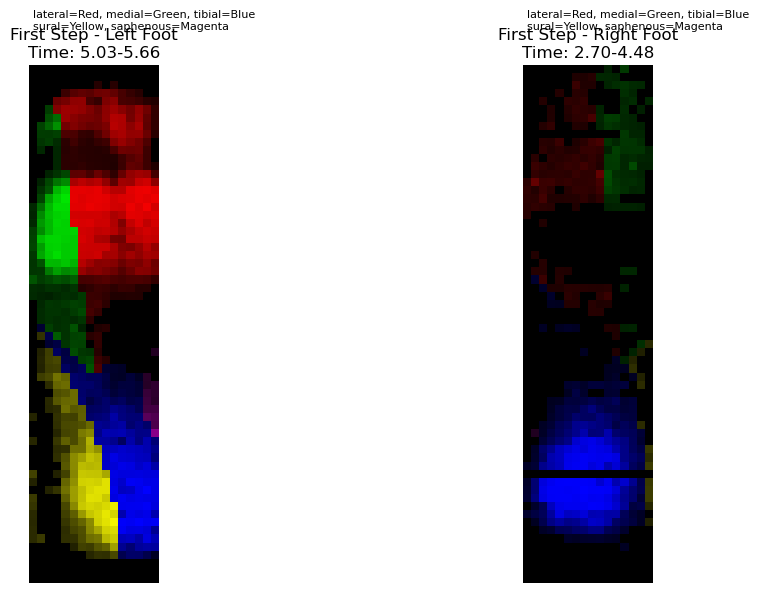

In [291]:
# Part 4: Visualize just the first step for each foot
# Get time ranges for first steps
# We already have first_step_l and first_step_r from earlier

# Get start and end time for the first left step
left_start_idx = first_step_l['strike'][0]
left_end_idx = first_step_l['off'][0] if first_step_l['off'] else first_step_l['strike'][1]
left_start_time = float(t_insole_l[left_start_idx][0])
left_end_time = float(t_insole_l[left_end_idx][0])
left_time_range = (left_start_time, left_end_time)

# Get start and end time for the first right step
right_start_idx = first_step_r['strike'][0]
right_end_idx = first_step_r['off'][0] if first_step_r['off'] else first_step_r['strike'][1]
right_start_time = float(t_insole_r[right_start_idx][0])
right_end_time = float(t_insole_r[right_end_idx][0])
right_time_range = (right_start_time, right_end_time)

# Define region colors
region_colors = {
    'lateral': np.array([1.0, 0.0, 0.0]),    # Red for lateral plantar
    'medial': np.array([0.0, 1.0, 0.0]),     # Green for medial plantar
    'tibial': np.array([0.0, 0.0, 1.0]),     # Blue for tibial
    'sural': np.array([1.0, 1.0, 0.0]),      # Yellow for sural
    'saphenous': np.array([1.0, 0.0, 1.0])   # Magenta for saphenous
}

# Build the color-coded images for first step of left and right feet
foot_left_img = build_first_step_color_image(
    'data_by_section/GAIT080624-01/walk_4/nerve/left_foot_lateral_plantar.csv',
    'data_by_section/GAIT080624-01/walk_4/nerve/left_foot_medial_plantar.csv',
    'data_by_section/GAIT080624-01/walk_4/nerve/left_foot_tibial.csv',
    'data_by_section/GAIT080624-01/walk_4/nerve/left_foot_sural.csv',
    'data_by_section/GAIT080624-01/walk_4/nerve/left_foot_saphenous.csv',
    region_colors,
    left_time_range
)

foot_right_img = build_first_step_color_image(
    'data_by_section/GAIT080624-01/walk_4/nerve/right_foot_lateral_plantar.csv',
    'data_by_section/GAIT080624-01/walk_4/nerve/right_foot_medial_plantar.csv',
    'data_by_section/GAIT080624-01/walk_4/nerve/right_foot_tibial.csv',
    'data_by_section/GAIT080624-01/walk_4/nerve/right_foot_sural.csv',
    'data_by_section/GAIT080624-01/walk_4/nerve/right_foot_saphenous.csv',
    region_colors,
    right_time_range
)

# Plot side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(foot_left_img, origin='upper')
plt.title(f"First Step - Left Foot\nTime: {left_time_range[0]:.2f}-{left_time_range[1]:.2f}")
# Add a legend for the left foot
legend_text = "lateral=Red, medial=Green, tibial=Blue\nsural=Yellow, saphenous=Magenta"
plt.text(0, -5, legend_text, fontsize=8, ha='left')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(foot_right_img, origin='upper')
plt.title(f"First Step - Right Foot\nTime: {right_time_range[0]:.2f}-{right_time_range[1]:.2f}")
# Add a legend for the right foot
plt.text(0, -5, legend_text, fontsize=8, ha='left')
plt.axis('off')

plt.tight_layout()
plt.show()